In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

d:\Application\Conda\envs\geoneuro\lib\site-packages\geopandas\_compat.py:153: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\Cover\AppData\Local\Temp\ipykernel_42472\1960879352.py:3: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [2]:
# read in the travel chain data
chain_pro = pd.read_csv('./data/sample/chain_pro_new_plus.csv')

In [3]:
stay = chain_pro[~chain_pro.isMove].copy()

stay.drop(columns=['isMove', 'poi_d', 'lambda_d', 'phi_d', 'mode'], inplace=True)
stay.rename(columns={'poi_o': 'poi', 'lambda_o': 'lambda', 'phi_o': 'phi'}, inplace=True)

In [4]:
stay

,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0
2,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0
4,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0
5,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0
7,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0
...,...,...,...,...,...,...,...,...,...
19361,102181433,20231229,3,2023-12-29 22:48:43,2023-12-29 23:59:03,0,113.973390,22.594425,1.0
19362,102181433,20231230,0,2023-12-30 00:00:05,2023-12-30 20:14:33,0,113.973390,22.594425,1.0
19364,102181433,20231230,1,2023-12-30 20:21:35,2023-12-30 23:58:19,0,113.973390,22.594425,1.0
19365,102181433,20231231,0,2023-12-31 00:00:22,2023-12-31 21:31:20,0,113.973390,22.594425,1.0


## Label the states

In [5]:
# 将经纬度(lambda/phi)转换为 EPSG:32650 投影坐标(米)，生成 x/y
# 输入: 已存在的 DataFrame `stay`，包含列 ['lambda','phi']

gdf = gpd.GeoDataFrame(
    stay.copy(),
    geometry=gpd.points_from_xy(stay['lambda'], stay['phi']),
    crs='EPSG:4326'
)

# 转换到 UTM Zone 50N (EPSG:32650)
gdf = gdf.to_crs(epsg=32650)

# 提取投影坐标为 x/y 列
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# 工作副本，后续聚类在 gdf 上进行
gdf.head()


,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype,geometry,x,y
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0,POINT (194414.952 2507882.981),194414.951879,2.507883e+06
2,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06
4,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06
5,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0,POINT (194256.862 2508484.714),194256.862442,2.508485e+06
7,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06


In [6]:
# 对每人分组，将点位在 200m 内均匀随机偏置后，用 HDBSCAN(min_cluster_size=5) 聚类
# 输出: DataFrame `stay_clustered`，新增列 'cluster_id'，-1 表示噪声

# 安装/导入 hdbscan
import hdbscan

# 为可复现实验设置全局随机数发生器（不固定也可删除该行）
RNG = np.random.default_rng(114514)

def jitter_within_radius(xy: np.ndarray, max_radius_m: float, rng: np.random.Generator) -> np.ndarray:
    """在半径 max_radius_m 的圆内，做均匀随机偏置（面积均匀）。"""
    n = xy.shape[0]
    angles = rng.uniform(0.0, 2.0 * np.pi, size=n)
    radii = max_radius_m * np.sqrt(rng.uniform(0.0, 1.0, size=n))
    offsets = np.column_stack([radii * np.cos(angles), radii * np.sin(angles)])
    return xy + offsets


def cluster_one_person(df_person: pd.DataFrame) -> pd.DataFrame:
    df_person = df_person.copy()
    xy = df_person[['x', 'y']].to_numpy(dtype=float)
    xy_jittered = jitter_within_radius(xy, max_radius_m=200.0, rng=RNG)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=6, min_samples=3, metric='euclidean')
    labels = clusterer.fit_predict(xy_jittered)
    df_person['cluster_id'] = labels
    return df_person

# 分组执行聚类（按 who）
stay_clustered = gdf.groupby('who', group_keys=False).apply(cluster_one_person)

# 生成一个紧凑的簇编号（可选）：将每个 who 内的簇标签映射到 0..K-1（保留噪声为 -1）
# 如需跨用户全局唯一，可删除以下代码。
def relabel_per_person(df_person: pd.DataFrame) -> pd.DataFrame:
    df_person = df_person.copy()
    labels = df_person['cluster_id'].to_numpy()
    unique_labels = [l for l in np.unique(labels) if l != -1]
    mapping = {l: i for i, l in enumerate(unique_labels)}
    df_person['cluster_id'] = np.where(labels == -1, -1, pd.Series(labels).map(mapping).to_numpy())
    return df_person

stay_clustered = stay_clustered.groupby('who', group_keys=False).apply(relabel_per_person)


d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

In [7]:
# 结果预览与简单统计
from IPython.display import display

display(stay_clustered.head(10))

# 每个 who 的簇数量与噪声占比（可选）
cluster_stats = (
    stay_clustered
    .assign(is_noise=lambda d: d['cluster_id'].eq(-1))
    .groupby('who')
    .agg(num_points=('cluster_id', 'size'),
         num_clusters=('cluster_id', lambda s: s.loc[s.ne(-1)].nunique()),
         noise_ratio=('is_noise', 'mean'))
    .reset_index()
)

display(cluster_stats.head(10))


,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype,geometry,x,y,cluster_id
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0,POINT (194414.952 2507882.981),194414.951879,2.507883e+06,10.0
2,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
4,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06,12.0
5,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0,POINT (194256.862 2508484.714),194256.862442,2.508485e+06,10.0
7,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
9,1102234,20230302,2,2023-03-02 22:23:22,2023-03-02 23:54:44,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06,12.0
10,1102234,20230303,0,2023-03-03 07:01:26,2023-03-03 07:36:17,13,114.034653,22.665482,0.0,POINT (195266.699 2509530.081),195266.698607,2.509530e+06,8.0
12,1102234,20230303,1,2023-03-03 07:46:08,2023-03-03 21:29:21,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
14,1102234,20230303,2,2023-03-03 21:44:41,2023-03-03 23:20:31,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06,12.0
15,1102234,20230304,0,2023-03-04 07:58:33,2023-03-04 08:50:21,0,114.026693,22.650468,1.0,POINT (194414.952 2507882.981),194414.951879,2.507883e+06,10.0


,who,num_points,num_clusters,noise_ratio
0,1102234,730,13,0.073973
1,4116450,800,6,0.037500
2,6945721,876,22,0.098174
3,10013454,143,2,0.181818
4,23951036,1064,18,0.073308
5,25679537,810,16,0.088889
6,26564845,481,7,0.051975
7,44777185,305,3,0.032787
8,47319758,342,10,0.210526
9,54636959,297,2,0.168350


In [8]:
# 地理可视化：为每个人分别创建交互式地图，不同簇用不同颜色标记
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 确保 stay_clustered 有经纬度信息（如果只有投影坐标，需要转换回来）
# 由于 stay_clustered 是从 gdf 来的，而 gdf 是从 stay 来的，应该还有原始的 lambda 和 phi
# 如果没有，需要从投影坐标转换回经纬度
if 'lambda' not in stay_clustered.columns or 'phi' not in stay_clustered.columns:
    # 从投影坐标转换回 WGS84
    gdf_wgs84 = stay_clustered.to_crs(epsg=4326)
    stay_clustered['lambda'] = gdf_wgs84.geometry.x
    stay_clustered['phi'] = gdf_wgs84.geometry.y

# 为簇创建颜色映射（使用 plotly 的离散颜色序列）
def get_cluster_colors(n_clusters):
    """为簇生成颜色，噪声用灰色"""
    # 使用 plotly 的定性颜色序列
    colors = px.colors.qualitative.Set3
    if n_clusters <= len(colors):
        return colors[:n_clusters]
    # 如果需要更多颜色，使用循环
    return (colors * ((n_clusters // len(colors)) + 1))[:n_clusters]

def plot_person_clusters(person_id, df_person):
    """为单个个体创建聚类可视化地图"""
    # 获取该个体的所有簇（排除噪声）
    unique_clusters = sorted([c for c in df_person['cluster_id'].unique() if c != -1])
    n_clusters = len(unique_clusters)
    
    if n_clusters == 0:
        print(f"个体 {person_id} 没有有效的簇（全部为噪声）")
        return None
    
    # 创建颜色映射
    cluster_colors = get_cluster_colors(n_clusters)
    color_map = {cluster: cluster_colors[i] for i, cluster in enumerate(unique_clusters)}
    color_map[-1] = 'gray'  # 噪声用灰色
    
    # 创建图形
    fig = go.Figure()
    
    # 为每个簇添加一个散点图层
    for cluster_id in unique_clusters:
        cluster_data = df_person[df_person['cluster_id'] == cluster_id]
        fig.add_trace(go.Scattermapbox(
            lat=cluster_data['phi'],
            lon=cluster_data['lambda'],
            mode='markers',
            marker=dict(
                size=8,
                color=color_map[cluster_id],
                opacity=0.7
            ),
            name=f'簇 {cluster_id}',
            text=[f"簇: {cluster_id}<br>POI: {poi}<br>日期: {date}" 
                  for poi, date in zip(cluster_data['poi'], cluster_data['date'])],
            hovertemplate='%{text}<extra></extra>',
            showlegend=True
        ))
    
    # 添加噪声点（如果有）
    noise_data = df_person[df_person['cluster_id'] == -1]
    if len(noise_data) > 0:
        fig.add_trace(go.Scattermapbox(
            lat=noise_data['phi'],
            lon=noise_data['lambda'],
            mode='markers',
            marker=dict(
                size=6,
                color='gray',
                opacity=0.5,
                symbol='x'
            ),
            name='噪声点',
            text=[f"噪声点<br>POI: {poi}<br>日期: {date}" 
                  for poi, date in zip(noise_data['poi'], noise_data['date'])],
            hovertemplate='%{text}<extra></extra>',
            showlegend=True
        ))
    
    # 设置地图布局
    fig.update_layout(
        title=f'个体 {person_id} 的活动地点聚类可视化',
        mapbox=dict(
            style='carto-positron',  # 使用灰度底图（无彩色）
            center=dict(
                lat=df_person['phi'].mean(),
                lon=df_person['lambda'].mean()
            ),
            zoom=11
        ),
        height=600,
        width=1000,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    return fig

# 选择前几个个体进行可视化（可以根据需要调整）
sample_persons = stay_clustered['who'].unique()[:5]  # 可视化前5个个体

for person_id in sample_persons:
    df_person = stay_clustered[stay_clustered['who'] == person_id]
    fig = plot_person_clusters(person_id, df_person)
    if fig is not None:
        fig.show()


In [9]:
stay_clustered

,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype,geometry,x,y,cluster_id
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0,POINT (194414.952 2507882.981),194414.951879,2.507883e+06,10.0
2,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
4,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06,12.0
5,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0,POINT (194256.862 2508484.714),194256.862442,2.508485e+06,10.0
7,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19361,102181433,20231229,3,2023-12-29 22:48:43,2023-12-29 23:59:03,0,113.973390,22.594425,1.0,POINT (188806.744 2501783.830),188806.743693,2.501784e+06,3.0
19362,102181433,20231230,0,2023-12-30 00:00:05,2023-12-30 20:14:33,0,113.973390,22.594425,1.0,POINT (188806.744 2501783.830),188806.743693,2.501784e+06,3.0
19364,102181433,20231230,1,2023-12-30 20:21:35,2023-12-30 23:58:19,0,113.973390,22.594425,1.0,POINT (188806.744 2501783.830),188806.743693,2.501784e+06,3.0
19365,102181433,20231231,0,2023-12-31 00:00:22,2023-12-31 21:31:20,0,113.973390,22.594425,1.0,POINT (188806.744 2501783.830),188806.743693,2.501784e+06,3.0


In [10]:
# 可选：可视化特定个体或使用不同的地图样式
# 示例：可视化特定个体
# person_id = 1102234  # 替换为你想要可视化的个体ID
# df_person = stay_clustered[stay_clustered['who'] == person_id]
# fig = plot_person_clusters(person_id, df_person)
# if fig is not None:
#     fig.show()

# 可选：使用不同的地图样式（需要 mapbox token）
# 在 plot_person_clusters 函数中，可以将 style 改为：
# - 'open-street-map' (免费，不需要 token)
# - 'carto-positron' (免费，不需要 token)
# - 'carto-darkmatter' (免费，不需要 token)
# - 'stamen-terrain' (免费，不需要 token)
# - 'mapbox://styles/mapbox/streets-v11' (需要 mapbox token)


## import the built environment

In [11]:
builtenv_path = 'E:/Programming/Python/project_GeoComputation/data/Shapefile/BuiltEnvironmentShenzhen_wgs84.shp'
# use geopandas to read the shapefile of the path
builtenv = gpd.read_file(builtenv_path)
# fill the na with zero
builtenv.fillna(0, inplace=True)

In [12]:
hexcell_path = 'E:\Programming\Python\project_GeoComputation\data\Shapefile\H3Grid_res_9.shp'
hexcell = gpd.read_file(hexcell_path)

In [13]:
# 提取每个个体每个锚点（簇）的特征向量
# 步骤：
# 1. 将 stay_clustered 中的点与 hexcell 做空间连接，匹配到 h3 网格
# 2. 通过 h3 网格编号与 builtenv 连接，获取特征向量
# 3. 对每个个体的每个簇，将所有活动记录的特征向量求平均（不做 unique，自然加权）

# # 首先，确保 stay_clustered 有 geometry 列（用于空间连接）
# if 'geometry' not in stay_clustered.columns:
#     # 从经纬度创建 geometry
#     stay_clustered_gdf = gpd.GeoDataFrame(
#         stay_clustered,
#         geometry=gpd.points_from_xy(stay_clustered['lambda'], stay_clustered['phi']),
#         crs='EPSG:4326'
#     )
# else:
#     stay_clustered_gdf = gpd.GeoDataFrame(stay_clustered, crs='EPSG:4326')
    
stay_clustered_gdf = stay_clustered.to_crs(epsg=4326)

# 确保 hexcell 和 builtenv 的坐标系一致（都是 WGS84）
if hexcell.crs != 'EPSG:4326':
    hexcell = hexcell.to_crs(epsg=4326)
if builtenv.crs != 'EPSG:4326':
    builtenv = builtenv.to_crs(epsg=4326)

# 步骤1：空间连接，将点匹配到 h3 网格
print("正在将活动记录匹配到 h3 网格...")
stay_with_hex = gpd.sjoin(
    stay_clustered_gdf,
    hexcell,
    how='left',
    predicate='within'
)

# 检查是否有匹配失败的记录
unmatched = stay_with_hex[stay_with_hex.index_right.isna()]
if len(unmatched) > 0:
    print(f"警告：有 {len(unmatched)} 条记录未能匹配到 h3 网格")
    print(f"未匹配记录占比: {len(unmatched) / len(stay_with_hex):.2%}")

# 查看 hexcell 和 builtenv 的列名，确定关联字段
print("\nhexcell 的列名:")
print(hexcell.columns.tolist())
print("\nbuiltenv 的列名:")
print(builtenv.columns.tolist())


正在将活动记录匹配到 h3 网格...

hexcell 的列名:
['h3_index', 'geometry']

builtenv 的列名:
['base_h3', 'population', 'road_len_m', 'intersecti', 'landuse_en', 'bus_stop_c', 'metro_stat', 'poi_servic', 'poi_shoppi', 'poi_leisur', 'poi_cultur', 'poi_medica', 'poi_cateri', 'area_sum', 'plot_sum', 'area_ratio', 'plot_ratio', 'geometry']


In [14]:
# 步骤2：通过 h3 网格编号与 builtenv 连接
# 需要确定 hexcell 和 builtenv 的关联字段
# 通常可能是 'h3_index', 'h3', 'index', 'id' 等

# 先查看 hexcell 和 builtenv 的前几行，确定关联字段
print("hexcell 前几行:")
print(hexcell.head(2))
print("\nbuiltenv 前几行:")
print(builtenv.head(2))

# 查找可能的关联字段（通常包含 'h3' 或 'index' 的列）
hexcell_cols = [col for col in hexcell.columns if 'h3' in col.lower() or 'index' in col.lower() or 'id' in col.lower()]
builtenv_cols = [col for col in builtenv.columns if 'h3' in col.lower() or 'index' in col.lower() or 'id' in col.lower()]

print(f"\nhexcell 中可能的关联字段: {hexcell_cols}")
print(f"builtenv 中可能的关联字段: {builtenv_cols}")


hexcell 前几行:
          h3_index                                           geometry
0  89411c3ab8bffff  POLYGON ((113.92341 22.82436, 113.92197 22.823...
1  89411c06d43ffff  POLYGON ((114.04048 22.67635, 114.03905 22.675...

builtenv 前几行:
           base_h3    population   road_len_m  intersecti  landuse_en  \
0  89411c3ab8bffff      2.999800     0.000000           0    0.062359   
1  89411c06d43ffff  12562.099945  2128.529018          16    1.173550   

   bus_stop_c  metro_stat  poi_servic  poi_shoppi  poi_leisur  poi_cultur  \
0         0.0           0    0.000000     0.00000    0.000000    0.000000   
1         6.0           1  101.693337   165.77407   12.537535   30.647307   

   poi_medica  poi_cateri       area_sum       plot_sum  area_ratio  \
0    0.000000    0.000000       0.000000       0.000000    0.000000   
1   19.502832  108.658634  165652.516223  906284.040669    0.230764   

   plot_ratio                                           geometry  
0    0.000000  POLYGON ((113.

In [15]:
# 步骤3：匹配特征向量并计算锚点特征（修正版）
# 关键信息：
# - hexcell 中的网格编码字段是 'h3_index'
# - builtenv 中的编号字段是 'base_h3'
# - 这两个字段可以直接连接匹配

# 从空间连接结果中获取 h3_index（来自 hexcell）
hexcell_join_col = 'h3_index'  # hexcell 中的字段
builtenv_join_col = 'base_h3'  # builtenv 中的字段

# 检查 h3_index 是否在 stay_with_hex 中
if hexcell_join_col not in stay_with_hex.columns:
    # 如果列名有冲突，sjoin 可能会添加后缀，尝试查找
    possible_cols = [col for col in stay_with_hex.columns 
                    if 'h3_index' in col.lower() or col.endswith('h3_index')]
    if possible_cols:
        hexcell_join_col = possible_cols[0]
        print(f"注意：使用列 '{hexcell_join_col}' 作为关联字段（原始列名可能有变化）")
    else:
        print(f"错误：在空间连接结果中找不到 'h3_index' 字段")
        print(f"stay_with_hex 的列: {stay_with_hex.columns.tolist()}")
        raise ValueError("无法找到 h3_index 字段，请检查空间连接结果")
else:
    print(f"找到关联字段: hexcell 的 '{hexcell_join_col}' -> builtenv 的 '{builtenv_join_col}'")

# 检查 builtenv 中是否有 base_h3 字段
if builtenv_join_col not in builtenv.columns:
    print(f"错误：builtenv 中找不到 '{builtenv_join_col}' 字段")
    print(f"builtenv 的列: {builtenv.columns.tolist()}")
    raise ValueError(f"builtenv 中缺少 '{builtenv_join_col}' 字段")

# 将 stay_with_hex 与 builtenv 连接
print(f"\n正在通过 '{hexcell_join_col}' -> '{builtenv_join_col}' 连接 builtenv 特征...")

# 获取 builtenv 中除了 geometry 和 base_h3 之外的所有特征列
feature_cols = [col for col in builtenv.columns 
               if col not in ['geometry', builtenv_join_col]]

print(f"找到 {len(feature_cols)} 个特征列")
print(f"特征列示例: {feature_cols[:5] if len(feature_cols) > 5 else feature_cols}")

# 执行连接：使用 hexcell 的 h3_index 和 builtenv 的 base_h3
stay_with_features = stay_with_hex.merge(
    builtenv[[builtenv_join_col] + feature_cols],
    left_on=hexcell_join_col,
    right_on=builtenv_join_col,
    how='left',
    suffixes=('', '_builtenv')
)

# 检查匹配情况
matched = stay_with_features[builtenv_join_col].notna()
print(f"\n匹配成功: {matched.sum()} / {len(stay_with_features)} ({matched.mean():.2%})")

# 只保留有特征向量的记录（排除噪声点和未匹配的记录）
stay_with_features_valid = stay_with_features[
    (stay_with_features[builtenv_join_col].notna())
].copy()

print(f"有效记录数（排除噪声和未匹配）: {len(stay_with_features_valid)}")


找到关联字段: hexcell 的 'h3_index' -> builtenv 的 'base_h3'

正在通过 'h3_index' -> 'base_h3' 连接 builtenv 特征...
找到 16 个特征列
特征列示例: ['population', 'road_len_m', 'intersecti', 'landuse_en', 'bus_stop_c']

匹配成功: 11833 / 11833 (100.00%)
有效记录数（排除噪声和未匹配）: 11833


In [16]:
# 步骤4：对每个个体的每个簇，计算平均特征向量
# 不做 unique，这样自然根据访问频次加权

# 检查必要的变量是否存在
if 'stay_with_features_valid' in locals() and 'feature_cols' in locals() and len(stay_with_features_valid) > 0:
    # 按 who 和 cluster_id 分组，对特征向量求平均
    print("\n正在计算每个锚点的平均特征向量...")
    
    # 分组聚合：对每个 (who, cluster_id) 组合，计算所有特征的平均值
    anchor_features = stay_with_features_valid.groupby(['who', 'cluster_id'])[feature_cols].mean().reset_index()
    
    # 添加一些统计信息：每个锚点的活动记录数
    anchor_stats = stay_with_features_valid.groupby(['who', 'cluster_id']).agg({
        'seqid': 'count',  # 活动记录数
        'lambda': 'mean',  # 锚点的平均经度
        'phi': 'mean'      # 锚点的平均纬度
    }).reset_index()
    anchor_stats.rename(columns={'seqid': 'num_visits'}, inplace=True)
    
    # 合并统计信息
    anchor_features = anchor_features.merge(anchor_stats, on=['who', 'cluster_id'], how='left')
    
    # 重新排列列的顺序，将基本信息放在前面
    cols_order = ['who', 'cluster_id', 'num_visits', 'lambda', 'phi'] + feature_cols
    anchor_features = anchor_features[cols_order]
    
    print(f"\n完成！共提取了 {len(anchor_features)} 个锚点的特征向量")
    print(f"涉及 {anchor_features['who'].nunique()} 个个体")
    print(f"平均每个个体有 {anchor_features.groupby('who').size().mean():.1f} 个锚点")
    
    # 显示结果预览
    print("\n锚点特征向量预览（前5行）:")
    print(anchor_features.head())
    
    # 显示每个锚点的访问次数统计
    print("\n每个锚点的访问次数统计:")
    print(anchor_features['num_visits'].describe())
    
else:
    print("请先完成前面的步骤（步骤3），确保 stay_with_features_valid 和 feature_cols 已设置")
    print("如果已运行步骤3，请检查是否有错误信息")



正在计算每个锚点的平均特征向量...

完成！共提取了 224 个锚点的特征向量
涉及 20 个个体
平均每个个体有 11.2 个锚点

锚点特征向量预览（前5行）:
       who  cluster_id  num_visits      lambda        phi    population  \
0  1102234        -1.0          54  114.059200  22.646824  21738.501776   
1  1102234         0.0           8  113.802567  22.649517   4597.613272   
2  1102234         1.0           8  114.065552  22.542400  27357.237472   
3  1102234         2.0           6  114.241791  22.718811  15282.710035   
4  1102234         3.0         164  114.055010  22.690067   7083.443374   

    road_len_m  intersecti  landuse_en  bus_stop_c  ...  poi_servic  \
0  4365.968491   37.611111    0.999388   10.314815  ...  226.597020   
1  1293.081640   10.000000    0.151605    2.750000  ...   79.254919   
2  5902.478010   53.625000    0.973172   13.625000  ...  495.546500   
3  4314.184904   33.000000    0.980981    7.166667  ...  219.352049   
4  3304.065343   19.621951    1.126330    5.902439  ...   49.016691   

   poi_shoppi  poi_leisur  poi_cultur

In [17]:
# 步骤4（修正版）：对每个个体的每个锚点，统一特征向量
# 任务：
# 1. 对于 cluster_id != -1 的锚点：计算该锚点所有活动点的特征向量平均值，然后赋值给该锚点的所有活动记录
# 2. 对于 cluster_id == -1 的噪声点：保留原始特征向量不变

# 检查必要的变量是否存在
if 'stay_with_features_valid' in locals() and 'feature_cols' in locals() and len(stay_with_features_valid) > 0:
    # 创建副本，避免修改原始数据
    stay_with_features_unified = stay_with_features_valid.copy()
    
    # 分离锚点（cluster_id != -1）和噪声点（cluster_id == -1）
    anchor_points = stay_with_features_unified[stay_with_features_unified['cluster_id'] != -1].copy()
    noise_points = stay_with_features_unified[stay_with_features_unified['cluster_id'] == -1].copy()
    
    print(f"\n正在统一每个锚点的特征向量...")
    print(f"锚点记录数: {len(anchor_points)}")
    print(f"噪声点记录数: {len(noise_points)}")
    
    if len(anchor_points) > 0:
        # 对每个 (who, cluster_id) 组合，计算特征向量的平均值
        anchor_avg_features = anchor_points.groupby(['who', 'cluster_id'])[feature_cols].mean().reset_index()
        
        # 将平均特征向量合并回原始数据
        # 使用 merge 将平均特征向量赋值给每个锚点的所有活动记录
        anchor_points = anchor_points.drop(columns=feature_cols).merge(
            anchor_avg_features,
            on=['who', 'cluster_id'],
            how='left'
        )
        
        print(f"已统一 {anchor_points['cluster_id'].nunique()} 个锚点的特征向量")
    
    # 合并锚点和噪声点（噪声点保持原始特征向量）
    stay_with_features_unified = pd.concat([anchor_points, noise_points], ignore_index=True)
    
    # 添加一些统计信息：每个锚点的活动记录数（仅用于显示）
    anchor_stats = stay_with_features_unified[stay_with_features_unified['cluster_id'] != -1].groupby(['who', 'cluster_id']).agg({
        'seqid': 'count',  # 活动记录数
        'lambda': 'mean',  # 锚点的平均经度
        'phi': 'mean'      # 锚点的平均纬度
    }).reset_index()
    anchor_stats.rename(columns={'seqid': 'num_visits'}, inplace=True)
    
    print(f"\n完成！")
    print(f"- 锚点记录数: {len(anchor_points)}（特征向量已统一）")
    print(f"- 噪声点记录数: {len(noise_points)}（特征向量保持原始值）")
    print(f"- 总记录数: {len(stay_with_features_unified)}")
    print(f"- 涉及 {stay_with_features_unified['who'].nunique()} 个个体")
    print(f"- 共有 {anchor_stats['cluster_id'].nunique()} 个锚点")
    
    # 验证：检查同一锚点的特征向量是否相同
    print("\n验证：检查同一锚点的特征向量是否统一...")
    sample_anchor = anchor_stats.head(1)
    if len(sample_anchor) > 0:
        sample_who = sample_anchor['who'].iloc[0]
        sample_cluster = sample_anchor['cluster_id'].iloc[0]
        sample_records = stay_with_features_unified[
            (stay_with_features_unified['who'] == sample_who) & 
            (stay_with_features_unified['cluster_id'] == sample_cluster)
        ]
        if len(sample_records) > 1:
            # 检查第一个特征列是否相同
            first_feature = feature_cols[0]
            if sample_records[first_feature].nunique() == 1:
                print(f"✓ 验证通过：锚点 ({sample_who}, {sample_cluster}) 的所有记录的特征向量已统一")
            else:
                print(f"✗ 验证失败：锚点 ({sample_who}, {sample_cluster}) 的特征向量未统一")
    
    # 显示结果预览
    print("\n统一后的数据预览（前5行）:")
    print(stay_with_features_unified.head())
    
else:
    print("请先完成前面的步骤（步骤3），确保 stay_with_features_valid 和 feature_cols 已设置")
    print("如果已运行步骤3，请检查是否有错误信息")



正在统一每个锚点的特征向量...
锚点记录数: 10768
噪声点记录数: 1065
已统一 22 个锚点的特征向量

完成！
- 锚点记录数: 10768（特征向量已统一）
- 噪声点记录数: 1065（特征向量保持原始值）
- 总记录数: 11833
- 涉及 20 个个体
- 共有 22 个锚点

验证：检查同一锚点的特征向量是否统一...
✓ 验证通过：锚点 (1102234, 0.0) 的所有记录的特征向量已统一

统一后的数据预览（前5行）:
       who      date  seqid              t_start                t_end  poi  \
0  1102234  20230301      0  2023-03-01 00:13:19  2023-03-01 07:29:20    0   
1  1102234  20230301      1  2023-03-01 07:40:33  2023-03-01 22:24:33    1   
2  1102234  20230301      2  2023-03-01 22:37:39  2023-03-01 22:42:41    4   
3  1102234  20230302      0  2023-03-02 07:06:49  2023-03-02 07:29:38   17   
4  1102234  20230302      1  2023-03-02 07:44:11  2023-03-02 22:09:46    1   

       lambda        phi  ptype                    geometry  ...  poi_servic  \
0  114.026693  22.650468    1.0  POINT (114.02669 22.65047)  ...  334.651332   
1  114.054908  22.690259    2.0  POINT (114.05491 22.69026)  ...   49.016691   
2  114.031448  22.653732    0.0  POINT (114.03145 22.65373) 

In [18]:
stay_with_features_unified  

,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype,geometry,...,poi_servic,poi_shoppi,poi_leisur,poi_cultur,poi_medica,poi_cateri,area_sum,plot_sum,area_ratio,plot_ratio
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0,POINT (114.02669 22.65047),...,334.651332,736.826999,87.783046,157.630638,56.356593,539.302647,179744.832261,1.225271e+06,0.250265,1.705987
1,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0,POINT (114.05491 22.69026),...,49.016691,42.439184,8.200613,10.801021,9.475325,28.944308,122246.946269,8.006757e+05,0.170373,1.115885
2,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0,POINT (114.03145 22.65373),...,250.121587,338.778474,45.753892,54.705815,49.467513,322.730624,141864.828713,8.933769e+05,0.197548,1.244037
3,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0,POINT (114.02504 22.65587),...,334.651332,736.826999,87.783046,157.630638,56.356593,539.302647,179744.832261,1.225271e+06,0.250265,1.705987
4,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0,POINT (114.05491 22.69026),...,49.016691,42.439184,8.200613,10.801021,9.475325,28.944308,122246.946269,8.006757e+05,0.170373,1.115885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11828,102181433,20231124,1,2023-11-24 18:03:58,2023-11-24 20:00:38,9,114.005814,22.550125,0.0,POINT (114.00581 22.55013),...,171.006465,382.331527,58.392451,66.734230,51.440969,183.519133,127546.670297,1.215553e+06,0.177328,1.689979
11829,102181433,20231207,2,2023-12-07 02:37:15,2023-12-07 03:42:08,10,113.981094,22.587204,0.0,POINT (113.98109 22.58720),...,23.634523,19.463725,4.170798,9.731863,0.000000,40.317716,70216.194598,3.230638e+05,0.097619,0.449145
11830,102181433,20231208,7,2023-12-08 18:32:51,2023-12-08 21:27:25,8,113.952255,22.546005,0.0,POINT (113.95226 22.54601),...,331.954494,787.523840,69.446547,88.891580,45.834721,322.231977,156792.243508,2.018933e+06,0.217774,2.804159
11831,102181433,20231214,3,2023-12-14 14:27:37,2023-12-14 17:19:15,3,113.916550,22.546005,0.0,POINT (113.91655 22.54601),...,270.674261,427.526526,69.403657,79.120169,65.239437,260.957749,174659.748109,1.090968e+06,0.242441,1.514343


## RL demo

In [19]:
inspect_user = 6945721


In [22]:
from typing import Any
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.optimize import minimize
from scipy.special import logsumexp
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------------------------------
# 配置：奖励函数形式
# 可选：'linear'（线性）、'power'（幂函数）、'log'（对数）
# 之后可以通过修改 REWARD_TYPE 来比较不同形式的拟合优度
# -----------------------------------------------------------------------------
REWARD_TYPE = 'log'

# -----------------------------------------------------------------------------
# 数据检查与预处理
# -----------------------------------------------------------------------------
if 'stay_with_features_unified' not in locals():
    raise RuntimeError("请先运行步骤4（修正版）以生成 stay_with_features_unified 数据。")

if 'inspect_user' not in locals():
    raise RuntimeError("请先设置 inspect_user，例如 inspect_user = 6945721。")

user_df = stay_with_features_unified[stay_with_features_unified['who'] == inspect_user].copy()

if user_df.empty:
    raise ValueError(f"未找到用户 {inspect_user} 的记录，请确认 inspect_user 的取值。")

# ! 这里不能把-1删掉。建议在这里用二层策略，以一定参数化概率概率选择探索或者利用，两者和为1
# ! 当选择利用的时候，会将已知的锚点作为动作空间，然后从中按照softmax策略进行选择
# ! 当选择探索的时候，去一个未知的地点，这里“未知”，指的是所有锚点编号为-1的地点，以及之前从未去过的锚点
# ! 当一个锚点（即不为-1）的点被选择后，它会被更新为已知，即下次选择的时候，它就会作为动作空间的一部分
# ! 模型拟合的时候，探索的概率作为参数进行估计
# 因此，这里不再删除 cluster_id == -1 的记录，而是在似然函数中显式建模“已知/未知”锚点和探索概率

if len(user_df) < 3:
    raise ValueError(f"用户 {inspect_user} 的锚点记录不足，无法进行强化学习建模。")

# 排序：按照起始时间顺序排列轨迹
for col in ['t_start', 't_end']:
    if user_df[col].dtype == object:
        user_df[col] = pd.to_datetime(user_df[col])

sort_cols = ['date', 't_start'] if 't_start' in user_df.columns else ['date']
user_df = user_df.sort_values(sort_cols).reset_index(drop=True)

# 状态序列（锚点编号）
states = user_df['cluster_id'].astype(int).to_numpy()

if len(np.unique(states)) < 2:
    raise ValueError("该用户只访问了一个锚点，无法建立状态转移模型。")

# 计算每条停留的停留时长（分钟），后续奖励只基于停留时长
# ! 奖励先不用特征向量的线性组合，而是使用在一个地点停留时间的函数
stay_minutes = (user_df['t_end'] - user_df['t_start']).dt.total_seconds() / 60.0
stay_minutes = stay_minutes.to_numpy()

# 保存日期序列，用于判断“当日最后一条轨迹”
if 'date' in user_df.columns:
    date_array = user_df['date'].to_numpy()
else:
    date_array = None

# 特征矩阵（每个锚点一行）——仍然保留，方便后续如需恢复到基于特征的奖励
state_feature_df = (
    user_df.drop_duplicates('cluster_id')
            .set_index('cluster_id')[feature_cols]
            .sort_index()
)
state_feature_df = state_feature_df.fillna(0.0)

# 有可能不需要scalar
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(state_feature_df.values)
# 添加常数项（偏置）
feature_matrix = np.hstack([feature_matrix, np.ones((feature_matrix.shape[0], 1))])
aug_feature_names = [f"{col}_std" for col in feature_cols] + ['bias']

# 每一行是一个唯一的锚点对应的特征向量
state_feature_matrix = {
    state: feature_matrix[idx]
    for idx, state in enumerate(state_feature_df.index.astype(int))
}

feature_dim = feature_matrix.shape[1]

# 所有非噪声锚点编号（用于构造“已知/未知”集合）
all_nonnoise_states = sorted(int(c) for c in np.unique(states) if c != -1)

# 为之后的 Sarsa 更新预先构造“是否还有同日下一步”的标记
n_steps = len(states)
n_transitions = n_steps - 1
same_day_next = np.zeros(n_transitions, dtype=bool)
if date_array is not None and n_transitions > 1:
    for t in range(n_transitions - 1):
        # 当前转移使用的是从 states[t] -> states[t+1]
        # 是否还存在同一天的下一条转移，取决于 states[t+1] 和 states[t+2] 是否同一天
        same_day_next[t] = (date_array[t + 1] == date_array[t + 2])

# -----------------------------------------------------------------------------
# 目标函数：给定参数，计算负对数似然
# 参数向量：
#   theta = [w (feature_dim), logit_alpha, log_beta, logit_epsilon, (logit_reward_param)]
# 其中：
#   - alpha = sigmoid(logit_alpha)   	\in (0, 1)
#   - beta  = exp(log_beta)        	\in (0, +inf)
#   - epsilon = sigmoid(logit_epsilon)   探索概率 \in (0, 1)
#   - reward_param 仅在 REWARD_TYPE 为 'power' 或 'log' 时启用，用于控制奖励函数形状
# -----------------------------------------------------------------------------

# 额外参数的个数（不包括 w）
extra_params = 3  # logit_alpha, log_beta, logit_epsilon
if REWARD_TYPE in ('power', 'log'):
    extra_params += 1  # 用于幂指数或对数系数

param_dim = feature_dim + extra_params


def unpack_params(theta):
    """将一维参数向量拆分为语义清晰的参数。"""
    w = theta[:feature_dim]
    idx = feature_dim

    logit_alpha = theta[idx]; idx += 1
    log_beta = theta[idx]; idx += 1
    logit_epsilon = theta[idx]; idx += 1

    alpha = 1 / (1 + np.exp(-logit_alpha))   # Sigmoid -> (0,1)
    beta = np.exp(log_beta)                  # Softplus (exp) -> (0,+inf)
    epsilon = 1 / (1 + np.exp(-logit_epsilon))  # 探索概率

    reward_param = None
    if REWARD_TYPE in ('power', 'log'):
        # 将 reward_param 约束在 (0,1)，便于表示幂指数或系数，满足边际递减
        logit_r = theta[idx]
        reward_param = 1 / (1 + np.exp(-logit_r))

    return w, alpha, beta, epsilon, reward_param


def compute_reward(t, reward_param):
    """根据停留时间计算奖励。

    对应注释中的三种形式：
    - 线性：r = time/30
    - 幂函数：r = (time/30)^gamma, gamma \in (0,1)
    - 对数函数：r = log(1 + c * time/30), c \in (0,1)
    """
    # 使用到达目标地点的停留时长作为奖励基准
    base = stay_minutes[t + 1] / 30.0
    base = max(base, 0.0)

    if REWARD_TYPE == 'linear' or reward_param is None:
        return float(base)
    elif REWARD_TYPE == 'power':
        gamma = reward_param
        return float(base ** gamma)
    elif REWARD_TYPE == 'log':
        c = reward_param
        return float(np.log1p(c * base))
    else:
        # 兜底：默认线性
        return float(base)


def simulate_and_loglik(theta):
    w, alpha, beta, epsilon, reward_param = unpack_params(theta)
    Q = defaultdict(float)
    loglik = 0.0

    # 已知锚点集合：初始化为第一条非噪声记录（如果存在）
    known_states = set()
    first_state = int(states[0])
    if first_state != -1:
        known_states.add(first_state)

    for t in range(n_transitions):
        s = int(states[t])
        a = int(states[t + 1])

        # 构造当前的“已知/未知”动作集合
        known_actions = sorted(st for st in known_states if st != -1)
        unknown_actions = []

        # 未知的非噪声锚点：在 all_nonnoise_states 中但尚未进入 known_states 的那些
        for st in all_nonnoise_states:
            if st not in known_states:
                unknown_actions.append(st)
        # 将 -1 视为“未知地点”的一类（如果在数据中出现）
        if -1 in states:
            unknown_actions.append(-1)

        # 如果完全没有候选动作，跳过该步（理论上不应发生）
        if not known_actions and not unknown_actions:
            continue

        # 计算利用策略（Softmax over Q）的概率分布
        if known_actions:
            q_values = np.array([Q[(s, a_candidate)] for a_candidate in known_actions])
            logits = beta * q_values
            probs_exploit = np.exp(logits - logsumexp(logits))
        else:
            probs_exploit = None

        # 二层策略：先在 {探索, 利用} 中选择，再在各自动作集合中选出具体动作
        if (probs_exploit is not None) and (a in known_actions):
            # 观测到的是“已知”锚点 -> 只能来自“利用”分支
            a_idx = known_actions.index(a)
            pa = (1.0 - epsilon) * probs_exploit[a_idx]
        elif a in unknown_actions and len(unknown_actions) > 0:
            # 观测到的是“未知”锚点（包括 cluster_id == -1）-> 来自“探索”分支
            pa = epsilon * (1.0 / len(unknown_actions))
        else:
            # 观测到的动作不在候选集合中（理论上不应该发生），跳过
            continue

        loglik += np.log(pa + 1e-12)

        # 计算奖励：仅基于停留时长的函数
        # ! 函数是有好几种形式：线性、幂函数、对数函数；通过 REWARD_TYPE 和 reward_param 控制
        # ! 最后可以比较不同 REWARD_TYPE 下的 AIC/BIC，以判断哪种形式更好
        reward = compute_reward(t, reward_param)

        # 计算下一动作（用于 Sarsa 更新）
        # ! 如果到达当日最后一条轨迹了，就不要差分了。因为这一条轨迹应该已经结束了
        # ! 也就是说，next_Q - Q[(s, a)]应该是0？
        if (t < n_transitions - 1) and (same_day_next[t]):
            a_next = int(states[t + 2])
            next_Q = Q[(a, a_next)]
        else:
            next_Q = 0.0

        delta = reward + next_Q - Q[(s, a)]
        Q[(s, a)] += alpha * delta
 
        # 更新“已知”锚点集合：一旦访问到非噪声锚点，就视为已知
        if a != -1:
            known_states.add(a)

    return -loglik  # 负对数似然


# -----------------------------------------------------------------------------
# 参数优化
# -----------------------------------------------------------------------------
initial_theta = np.zeros(param_dim)  # w 初始化为 0，其他参数也从 0 的 logit/log 开始
opt_result = minimize(
    simulate_and_loglik,
    initial_theta,
    method='L-BFGS-B'
)

if not opt_result.success:
    print("警告：优化未完全收敛 ->", opt_result.message)

final_theta = opt_result.x
final_w, final_alpha, final_beta, final_epsilon, final_reward_param = unpack_params(final_theta)
final_loglik = -opt_result.fun

# 计算实际参与模型拟合的参数个数
# 注意：w 向量虽然存在于参数向量中，但当前奖励函数不依赖它（奖励仅基于停留时长）
# 因此 w 不计入参数个数，只计算实际影响似然函数的参数：alpha, beta, epsilon, (reward_param)
k_params = extra_params

AIC = 2 * k_params - 2 * final_loglik
BIC = k_params * np.log(n_transitions) - 2 * final_loglik

# 将权重还原到原始特征空间（不含常数项）——虽然当前奖励不依赖特征，但保留该部分便于后续扩展
if feature_dim > 1:  # 至少包含一个真实特征 + 偏置
    original_weights = final_w[:-1] / scaler.scale_
    intercept = final_w[-1] - np.sum((scaler.mean_ / scaler.scale_) * final_w[:-1])
else:
    original_weights = np.array([])
    intercept = 0.0

model_summary = {
    'user_id': inspect_user,
    'n_states': int(len(state_feature_df)),
    'n_transitions': int(n_transitions),
    'log_likelihood': float(final_loglik),
    'AIC': float(AIC),
    'BIC': float(BIC),
    'alpha': float(final_alpha),
    'beta': float(final_beta),
    'epsilon_explore': float(final_epsilon),
    'reward_type': REWARD_TYPE,
    'reward_param': (None if final_reward_param is None else float(final_reward_param)),
    # 'weights_standardized': dict(zip(aug_feature_names, final_w)) if len(final_w) == len(aug_feature_names) else {},
    # 'weights_original': dict(zip(feature_cols, original_weights)) if original_weights.size == len(feature_cols) else {},
    # 'intercept_original': float(intercept)
}

print("强化学习模型拟合完成：")
print(pd.Series({k: v for k, v in model_summary.items() if k not in ['weights_standardized', 'weights_original']}))
# print("\n标准化特征权重：")
# print(pd.Series(model_summary['weights_standardized']))
# print("\n原始尺度特征权重：")
# print(pd.Series(model_summary['weights_original']))

# 可选择保存结果
rl_model_result = model_summary


强化学习模型拟合完成：
user_id                6945721
n_states                    23
n_transitions              875
log_likelihood    -1965.436938
AIC                3936.873876
BIC                3951.196548
alpha                 0.367598
beta                  0.101643
epsilon_explore       0.122286
reward_type             linear
reward_param              None
dtype: object


In [21]:
del stay_with_hex, stay_with_features_valid, stay_with_features
del stay_clustered, stay_clustered_gdf, matched, hexcell, gdf, builtenv

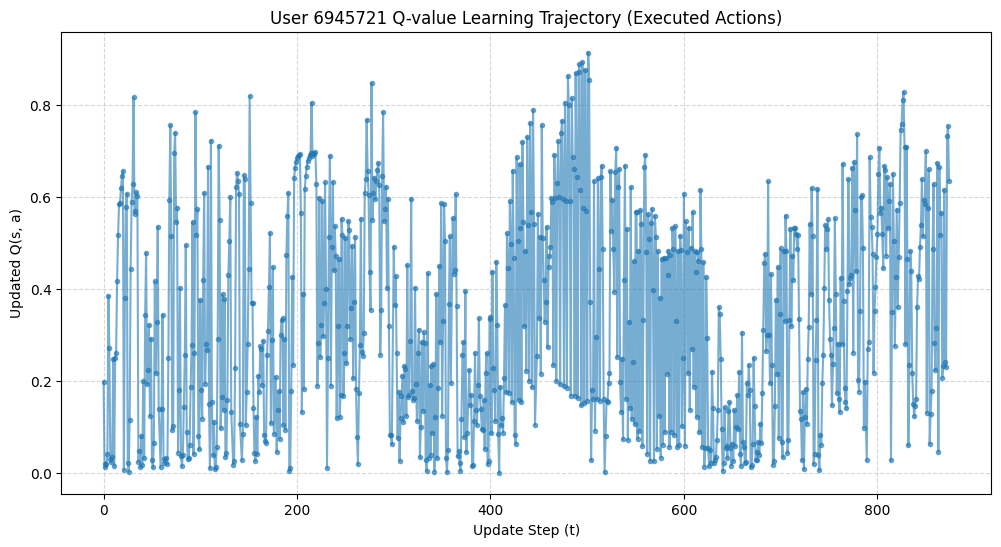

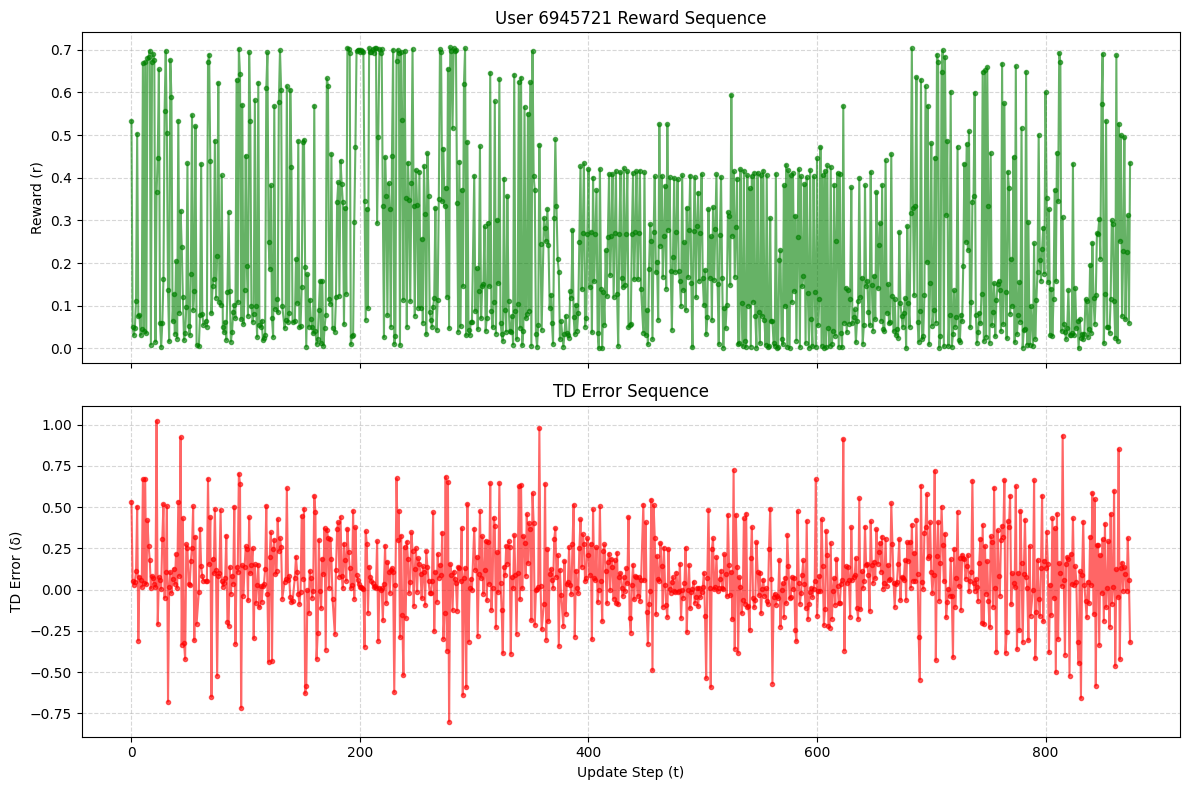


Q-value Trajectories for Each State-Action Pair (Partial Preview):
state  -1                                       ...  20          21          \
action  0   1   2   3   4   5   6   7   8   9   ...  19  20  21 -1   0   8    
step                                            ...                           
0      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
1      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
2      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
3      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
4      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
5      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
6      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
7      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
8      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN

In [31]:
import matplotlib.pyplot as plt
from collections import defaultdict

# -----------------------------------------------------------------------------
# 可视化学习过程：追踪每一步更新后的 Q 值
# -----------------------------------------------------------------------------

if 'model_summary' not in locals():
    raise RuntimeError("请先运行强化学习建模单元以获取 model_summary。")

# 重新提取最终参数（匹配新的参数结构）
def unpack_params_viz(theta):
    """用于可视化的参数解包函数，匹配新的模型结构"""
    w = theta[:feature_dim]
    idx = feature_dim
    
    logit_alpha = theta[idx]; idx += 1
    log_beta = theta[idx]; idx += 1
    logit_epsilon = theta[idx]; idx += 1
    
    alpha = 1 / (1 + np.exp(-logit_alpha))
    beta = np.exp(log_beta)
    epsilon = 1 / (1 + np.exp(-logit_epsilon))
    
    reward_param = None
    if REWARD_TYPE in ('power', 'log'):
        logit_r = theta[idx]
        reward_param = 1 / (1 + np.exp(-logit_r))
    
    return w, alpha, beta, epsilon, reward_param

if 'final_theta' not in locals():
    raise RuntimeError("缺少 final_theta，请重新运行强化学习建模单元。")

# 检查必要的全局变量是否存在
if 'states' not in locals() or 'n_transitions' not in locals():
    raise RuntimeError("缺少 states 或 n_transitions，请重新运行强化学习建模单元。")

if 'stay_minutes' not in locals():
    raise RuntimeError("缺少 stay_minutes，请重新运行强化学习建模单元。")

if 'same_day_next' not in locals():
    raise RuntimeError("缺少 same_day_next，请重新运行强化学习建模单元。")

if 'all_nonnoise_states' not in locals():
    raise RuntimeError("缺少 all_nonnoise_states，请重新运行强化学习建模单元。")

final_w, final_alpha, final_beta, final_epsilon, final_reward_param = unpack_params_viz(final_theta)

# 重新模拟学习过程（匹配新的模型逻辑）
def simulate_learning(alpha, reward_param):
    """重新模拟学习过程，使用新的奖励函数和已知/未知集合逻辑"""
    Q = defaultdict(float)
    records = []
    
    # 已知锚点集合：初始化为第一条非噪声记录（如果存在）
    known_states = set()
    first_state = int(states[0])
    if first_state != -1:
        known_states.add(first_state)
    
    def compute_reward(t, reward_param):
        """根据停留时间计算奖励（与主模型一致）"""
        base = stay_minutes[t + 1] / 30.0
        base = max(base, 0.0)
        
        if REWARD_TYPE == 'linear' or reward_param is None:
            return float(base)
        elif REWARD_TYPE == 'power':
            gamma = reward_param
            return float(base ** gamma)
        elif REWARD_TYPE == 'log':
            c = reward_param
            return float(np.log1p(c * base))
        else:
            return float(base)

    for t in range(n_transitions):
        s = int(states[t])
        a = int(states[t + 1])
        
        # 跳过无法处理的转移（理论上不应发生）
        if s == -1 and a == -1:
            continue
        
        q_before = Q[(s, a)]
        
        # 计算奖励：仅基于停留时长的函数
        reward = compute_reward(t, reward_param)
        
        # 计算下一动作（用于 Sarsa 更新）
        # 如果到达当日最后一条轨迹了，next_Q = 0
        if (t < n_transitions - 1) and (same_day_next[t]):
            a_next = int(states[t + 2])
            next_Q = Q[(a, a_next)]
        else:
            next_Q = 0.0
        
        delta = reward + next_Q - Q[(s, a)]
        Q[(s, a)] += alpha * delta
        
        # 更新"已知"锚点集合：一旦访问到非噪声锚点，就视为已知
        if a != -1:
            known_states.add(a)
        
        records.append({
            'step': t,
            'state': s,
            'action': a,
            'q_before': q_before,
            'q_after': Q[(s, a)],
            'reward': reward,
            'td_error': delta,
            'is_known': (a in known_states) if a != -1 else False
        })
    
    return pd.DataFrame(records)

learning_history = simulate_learning(final_alpha, final_reward_param)

if learning_history.empty:
    raise ValueError("学习轨迹为空，请检查输入数据。")

# Visualization: Q-values after each update
plt.figure(figsize=(12, 6))
plt.plot(learning_history['step'], learning_history['q_after'], marker='o', linestyle='-', markersize=3, alpha=0.6)
plt.xlabel('Update Step (t)')
plt.ylabel('Updated Q(s, a)')
plt.title(f'User {inspect_user} Q-value Learning Trajectory (Executed Actions)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Visualization: Reward and TD Error
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(learning_history['step'], learning_history['reward'], marker='o', linestyle='-', markersize=3, alpha=0.6, color='green')
axes[0].set_ylabel('Reward (r)')
axes[0].set_title(f'User {inspect_user} Reward Sequence')
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(learning_history['step'], learning_history['td_error'], marker='o', linestyle='-', markersize=3, alpha=0.6, color='red')
axes[1].set_xlabel('Update Step (t)')
axes[1].set_ylabel('TD Error (δ)')
axes[1].set_title('TD Error Sequence')
axes[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Pivot table to view Q-value trajectories for each state-action pair
pivot_q = learning_history.pivot_table(
    index='step', columns=['state', 'action'], values='q_after', aggfunc='last'
)
print("\nQ-value Trajectories for Each State-Action Pair (Partial Preview):")
print(pivot_q.head(10))


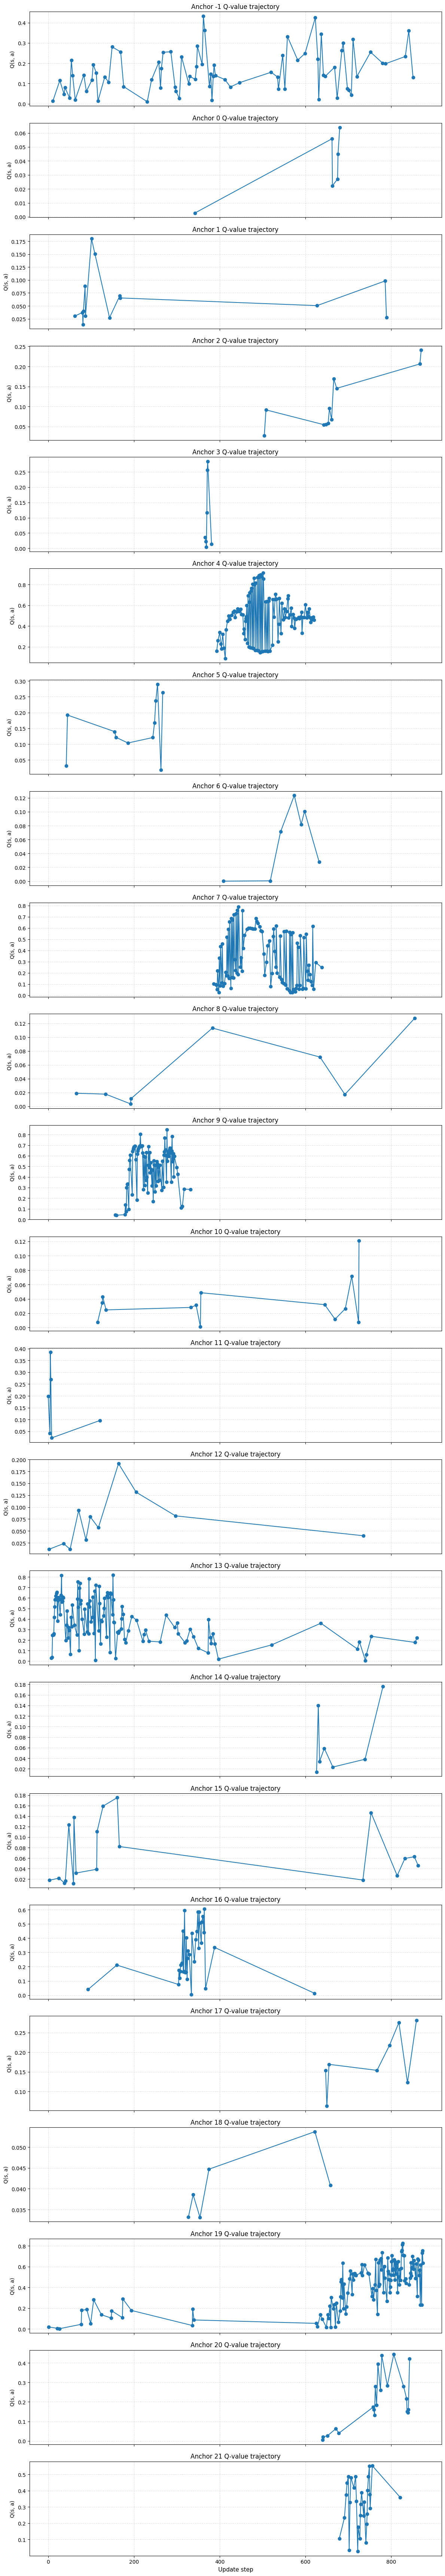

In [32]:
# -----------------------------------------------------------------------------
# Visualize Q-value trajectories per anchor & create interactive anchor map
# -----------------------------------------------------------------------------
import plotly.express as px

if 'learning_history' not in locals():
    raise RuntimeError("learning_history is missing. Please run the learning simulation cell first.")

# --- 1. Line charts for each anchor (destination state) ---
anchor_ids = sorted(learning_history['action'].unique())
if len(anchor_ids) == 0:
    raise ValueError("No anchor transitions found in learning_history.")

fig, axes = plt.subplots(len(anchor_ids), 1, figsize=(12, max(3 * len(anchor_ids), 4)), sharex=True)
if len(anchor_ids) == 1:
    axes = [axes]

for ax, anchor in zip(axes, anchor_ids):
    anchor_history = learning_history[learning_history['action'] == anchor]
    ax.plot(anchor_history['step'], anchor_history['q_after'], marker='o', linestyle='-')
    ax.set_title(f'Anchor {anchor} Q-value trajectory', fontsize=12)
    ax.set_ylabel('Q(s, a)', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel('Update step', fontsize=11)
plt.tight_layout()
plt.show()

# --- 2. Interactive map of anchors for the inspected user ---
user_anchor_geo = (
    stay_with_features_unified[
        (stay_with_features_unified['who'] == inspect_user) &
        (stay_with_features_unified['cluster_id'] != -1)
    ]
    .groupby('cluster_id')
    .agg(
        num_visits=('seqid', 'count'),
        lon=('lambda', 'mean'),
        lat=('phi', 'mean')
    )
    .reset_index()
)

if user_anchor_geo.empty:
    raise ValueError(f"User {inspect_user} has no non-noise anchors to visualize.")

map_fig = px.scatter_mapbox(
    user_anchor_geo,
    lat='lat',
    lon='lon',
    size='num_visits',
    color='cluster_id',
    hover_data={'cluster_id': True, 'num_visits': True, 'lat': ':.5f', 'lon': ':.5f'},
    title=f'Anchor locations for user {inspect_user}',
    zoom=10,
    height=500
)
map_fig.update_layout(mapbox_style='open-street-map', margin={'l': 0, 'r': 0, 't': 40, 'b': 0})
map_fig.show()


## Episodic RL

In [ ]:

# ! 现在请你在上面时序差分学习算法的基础上，再写一个利用情景记忆的Episodic RL建模方法。
# ! 仍然是，个体进行二层策略，当选择利用的时候，跟据Q函数的softmax进行决策。
# ! 对动作值函数的估计，是通过过往的轨迹记忆来实现的。所有之前走过的轨迹记忆都会被存储到记忆中。
# ! 然后在决策时对每一个动作的Q函数估计，等于记忆中累积回报的核函数相似度加权
# ! 假设现在在地点s3，需要评估所有动作函数Q(s3, a)，其中a为s1, s2, s3, ..., sK，即所有当下有记忆的锚点
# ! 这个时候，从记忆中选择出所有以a为目的地的轨迹，然后计算这些轨迹从a开始往后的累积回报，
# ! 然后用核函数加权算出加权平均，核函数是这样设计的：记忆轨迹中a作为目的地，假设对应的出发地（即前一个状态为o）
# ! 那么核函数为时间相似性核和空间相似性核的乘积，其中时间相似性核为：
# !     k_t(s3, o) = exp(-|theta|^2 / 2sigma_t^2)
# !     其中theta是s3和o在它们各自活动的时间结束时，时间差的角度表示，
# !     24h对应2*pi, 一个小时即为pi/12, 因此theta即对应的角度大小
# !     sigma_t是时间核的带宽，是待拟合的参数。
# ! 空间相似性核为：
# !     k_s(s3, o) = exp(-|d|^2 / 2sigma_s^2)
# !     其中d是两个地点之间的地理距离，sigma_s是空间核的带宽，也是待拟合的参数
# ! 这样就可以得到权重，然后，将所有累积回报按照这些权平均，作为Q(s3, a)的估计


In [27]:
from typing import Any
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
from scipy.special import logsumexp

# -----------------------------------------------------------------------------
# Episodic RL with kernel-weighted memory（固定核带宽 + 拟合 top-K）
# -----------------------------------------------------------------------------
if 'user_df' not in locals() or user_df.empty:
    raise RuntimeError('请先运行强化学习建模的数据准备单元，确保 user_df 等变量已就绪。')

if 'states' not in locals() or len(states) < 2:
    raise RuntimeError('缺少状态序列 states，请先运行前面的 TD RL 单元。')

if 'stay_minutes' not in locals():
    raise RuntimeError('缺少 stay_minutes，请先运行前面的 TD RL 单元。')

if 'all_nonnoise_states' not in locals():
    raise RuntimeError('缺少 all_nonnoise_states，请先运行前面的 TD RL 单元。')

n_steps = len(states)
n_transitions = n_steps - 1
if n_transitions <= 0:
    raise RuntimeError('状态序列过短，无法建模。')

# --- Helper data: time angles & state coordinates ---
SECONDS_PER_DAY = 24 * 3600

def to_time_angle(series):
    seconds = (
        series.dt.hour * 3600
        + series.dt.minute * 60
        + series.dt.second
        + series.dt.microsecond / 1e6
    ).to_numpy()
    return 2 * np.pi * ((seconds % SECONDS_PER_DAY) / SECONDS_PER_DAY)

if user_df['t_end'].isna().any():
    raise ValueError('t_end 含有缺失值，无法计算时间相似核。')

time_angles = to_time_angle(user_df['t_end'])  # 每个停留记录的离开时间角度

state_coords = (
    user_df.groupby('cluster_id')[['phi', 'lambda']]
    .mean()
    .rename(columns={'phi': 'lat', 'lambda': 'lon'})
    .to_dict('index')
)

# 每个转移动作对应的日期（用于按天截断累计回报）
if 'date_array' in locals() and date_array is not None:
    transition_days = date_array[1:]
    if len(transition_days) != n_transitions:
        raise RuntimeError('transition_days 长度与 n_transitions 不一致，请检查 date_array 与状态序列的对齐。')
else:
    transition_days = None


def get_coord(state):
    info = state_coords.get(state)
    if info is None:
        return None
    return info['lat'], info['lon']

# --- Distance & angle utilities ---
EARTH_RADIUS_M = 6371.0  # 单位 km

def haversine(coord_a, coord_b):
    if coord_a is None or coord_b is None:
        return np.nan
    lat1, lon1 = np.radians(coord_a)
    lat2, lon2 = np.radians(coord_b)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    h = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    return 2 * EARTH_RADIUS_M * np.arcsin(np.sqrt(h))

def angular_diff(a, b):
    diff = np.abs(a - b)
    return np.minimum(diff, 2 * np.pi - diff)

# --- Reward helpers（重用停留时长奖励定义） ---
def compute_reward_array(reward_param):
    base = np.maximum(stay_minutes[1:] / 30.0, 0.0)
    if REWARD_TYPE == 'linear' or reward_param is None:
        rewards = base
    elif REWARD_TYPE == 'power':
        rewards = np.power(base, reward_param)
    elif REWARD_TYPE == 'log':
        rewards = np.log1p(reward_param * base)
    else:
        rewards = base
    return np.nan_to_num(rewards, nan=0.0, posinf=0.0, neginf=0.0)


def cumulative_returns_by_day(reward_array, day_index=None):
    """按天分段计算从当前转移到当日结束的累计回报。"""
    if day_index is None:
        returns = np.zeros_like(reward_array)
        acc = 0.0
        for idx in range(len(reward_array) - 1, -1, -1):
            acc += reward_array[idx]
            returns[idx] = acc
        return returns

    if len(reward_array) != len(day_index):
        raise ValueError('reward_array 与 day_index 长度不一致。')

    returns = np.zeros_like(reward_array)
    acc = 0.0
    for idx in range(len(reward_array) - 1, -1, -1):
        if idx == len(reward_array) - 1 or day_index[idx] != day_index[idx + 1]:
            acc = 0.0
        acc += reward_array[idx]
        returns[idx] = acc
    return returns

# --- Parameter unpacking ---
# 固定核带宽（sigma_t, sigma_s），但将 K 作为待估计的 top-K 最近邻个数（1-50）
extra_params_epi = 3  # log_beta, logit_epsilon, raw_K
if REWARD_TYPE in ('power', 'log'):
    extra_params_epi += 1  # 多一个 reward_param
param_dim_epi = extra_params_epi


def unpack_params_epi(theta):
    idx = 0
    log_beta = theta[idx]; idx += 1
    logit_eps = theta[idx]; idx += 1
    raw_K = theta[idx]; idx += 1

    beta = np.exp(log_beta)
    epsilon = 1 / (1 + np.exp(-logit_eps))

    # 固定核带宽
    sigma_t = np.pi / 3.0   # 时间核：pi/3
    sigma_s = 1.5           # 空间核：1.5 km

    # 将 raw_K（实数）映射到整数 K ∈ [1, 50]
    K_cont = 1.0 + 49.0 / (1.0 + np.exp(-raw_K))
    K = int(np.round(K_cont))
    K = max(1, min(50, K))

    reward_param = None
    if REWARD_TYPE in ('power', 'log'):
        logit_r = theta[idx]
        reward_param = 1 / (1 + np.exp(-logit_r))

    return beta, epsilon, K, sigma_t, sigma_s, reward_param

# --- Q-value estimation from episodic memory (top-K) ---
def estimate_q(current_state, current_angle, action, memory, inv_sigma_t_sq, inv_sigma_s_sq, K):
    """使用 top-K 最近邻（按核权重最高的 K 条记忆）估计 Q 值。"""
    entries = memory.get(action)
    if not entries:
        return 0.0
    current_coord = get_coord(current_state)
    if current_coord is None:
        return 0.0

    n_entries = len(entries)
    if n_entries == 0:
        return 0.0

    origin_coords = [e['origin_coord'] for e in entries]
    origin_angles = np.array([e['origin_angle'] for e in entries], dtype=np.float64)
    returns = np.array([e['return'] for e in entries], dtype=np.float64)

    # 时间核
    angle_diffs = np.abs(origin_angles - current_angle)
    angle_diffs = np.minimum(angle_diffs, 2 * np.pi - angle_diffs)
    time_weights = np.exp(-0.5 * angle_diffs * angle_diffs * inv_sigma_t_sq)

    # 空间核
    space_weights = np.zeros(n_entries, dtype=np.float64)
    valid_mask = np.ones(n_entries, dtype=bool)
    for i, origin_coord in enumerate(origin_coords):
        if origin_coord is None:
            valid_mask[i] = False
            continue
        dist = haversine(current_coord, origin_coord)
        if np.isnan(dist):
            valid_mask[i] = False
            continue
        space_weights[i] = np.exp(-0.5 * dist * dist * inv_sigma_s_sq)

    weights = time_weights * space_weights
    valid_mask = valid_mask & (weights > 1e-12)

    if not valid_mask.any():
        return 0.0

    weights_valid = weights[valid_mask]
    returns_valid = returns[valid_mask]

    n_valid = len(weights_valid)
    k_actual = min(K, n_valid)
    if k_actual <= 0:
        return 0.0

    if k_actual < n_valid:
        top_idx = np.argpartition(weights_valid, -k_actual)[-k_actual:]
        w_top = weights_valid[top_idx]
        r_top = returns_valid[top_idx]
    else:
        w_top = weights_valid
        r_top = returns_valid

    return float(np.dot(w_top, r_top) / w_top.sum())

# --- Main objective ---
all_known_candidates = sorted(int(s) for s in np.unique(states) if s != -1)
include_noise = -1 in states


def simulate_and_loglik_epi(theta):
    beta, epsilon, K, sigma_t, sigma_s, reward_param = unpack_params_epi(theta)
    reward_array = compute_reward_array(reward_param)
    # 按天截断累计回报：每一天作为单独的 episode
    returns = cumulative_returns_by_day(reward_array, transition_days)

    # 预计算常量，避免重复计算
    inv_sigma_t_sq = 1.0 / (sigma_t * sigma_t)
    inv_sigma_s_sq = 1.0 / (sigma_s * sigma_s)

    memory = defaultdict(list)  # action -> list of dicts
    known_actions = set[Any]()
    loglik = 0.0
    # 缓存已知动作列表，避免每次循环都重新排序
    known_list_cached = []
    known_list_dirty = True  # 标记是否需要更新缓存

    for t in range(n_transitions):
        s = int(states[t])
        a = int(states[t + 1])
        current_angle = time_angles[t]

        # 检查是否为跨日期的转移：如果出发地和目的地不在同一天，跳过
        if date_array is not None and date_array[t] != date_array[t + 1]:
            continue

        # 只在 memory 更新时才重新计算 known_list
        if known_list_dirty:
            known_list_cached = sorted(memory.keys())
            known_list_dirty = False

        known_list = known_list_cached
        unknown_list = [act for act in all_known_candidates if act not in known_list]
        if include_noise:
            unknown_noise = -1
            if unknown_noise not in known_list and unknown_noise not in unknown_list:
                unknown_list.append(unknown_noise)

        q_values = []
        if known_list:
            for act in known_list:
                q_values.append(
                    estimate_q(s, current_angle, act, memory, inv_sigma_t_sq, inv_sigma_s_sq, K)
                )
            q_values = np.asarray(q_values)
            logits = beta * q_values
            probs_exploit = np.exp(logits - logsumexp(logits))
        else:
            probs_exploit = None

        # 二层策略：先选择“利用/探索”，再在对应集合中选动作
        if probs_exploit is not None and a in known_list:
            idx = known_list.index(a)
            pa = (1.0 - epsilon) * probs_exploit[idx]
        elif a in unknown_list and len(unknown_list) > 0:
            pa = epsilon * (1.0 / len(unknown_list))
        else:
            pa = 1e-12  # 避免零概率导致 -inf

        loglik += np.log(pa + 1e-12)

        # 将当前轨迹存入记忆：仅在“当天最后一条转移”时，对非噪声锚点建立记忆
        if a != -1:
            # 判断是否为当日最后一条转移
            if transition_days is None:
                is_end_of_day = (t == n_transitions - 1)
            else:
                if t == n_transitions - 1:
                    is_end_of_day = True
                else:
                    is_end_of_day = (transition_days[t] != transition_days[t + 1])

            if is_end_of_day:
                # 一天结束时，将当日所有转移 (s_k -> a_k) 的回报写入记忆
                if transition_days is not None:
                    current_day = transition_days[t]
                    day_indices = np.where(transition_days == current_day)[0]
                else:
                    # 没有日期信息时，视为单个 episode，将全部转移作为一日写入
                    day_indices = np.arange(n_transitions)

                for k in day_indices:
                    s_k = int(states[k])
                    a_k = int(states[k + 1])
                    if a_k == -1:
                        continue  # 仅对非噪声锚点建立记忆
                    origin_coord_k = get_coord(s_k)
                    if origin_coord_k is None:
                        continue
                    memory[a_k].append({
                        'origin_state': s_k,
                        'origin_coord': origin_coord_k,
                        'origin_angle': time_angles[k],
                        'return': returns[k]
                    })
                    known_actions.add(a_k)
                    known_list_dirty = True  # 标记缓存需要更新

    return -loglik  # 负对数似然

# --- 训练 Episodic RL 模型 ---
initial_theta = np.zeros(param_dim_epi)
opt_result_epi = minimize(
    simulate_and_loglik_epi,
    initial_theta,
    method='L-BFGS-B'
)

if not opt_result_epi.success:
    print('警告：Episodic RL 优化未完全收敛 ->', opt_result_epi.message)

final_theta_epi = opt_result_epi.x
beta_epi, epsilon_epi, K_epi, sigma_t_epi, sigma_s_epi, reward_param_epi = unpack_params_epi(final_theta_epi)
final_loglik_epi = -opt_result_epi.fun
k_params_epi = param_dim_epi

AIC_epi = 2 * k_params_epi - 2 * final_loglik_epi
BIC_epi = k_params_epi * np.log(n_transitions) - 2 * final_loglik_epi

episodic_rl_summary = {
    'user_id': inspect_user,
    'n_transitions': int(n_transitions),
    'log_likelihood': float(final_loglik_epi),
    'AIC': float(AIC_epi),
    'BIC': float(BIC_epi),
    'beta': float(beta_epi),
    'epsilon_explore': float(epsilon_epi),
    'K_top_neighbors': int(K_epi),
    'sigma_time': float(sigma_t_epi),
    'sigma_space_m': float(sigma_s_epi),
    'reward_type': REWARD_TYPE,
    'reward_param': None if reward_param_epi is None else float(reward_param_epi)
}

print('Episodic RL 模型拟合完成：')
print(pd.Series(episodic_rl_summary))

# 存储结果供后续使用
episodic_rl_result = episodic_rl_summary

Episodic RL 模型拟合完成：
user_id                6945721
n_transitions              875
log_likelihood    -1745.861745
AIC                 3499.72349
BIC                3518.820386
beta                  0.617421
epsilon_explore       0.159722
K_top_neighbors             26
sigma_time            1.047198
sigma_space_m              1.5
reward_type                log
reward_param          0.044776
dtype: object


In [24]:
from typing import Any
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
from scipy.special import logsumexp

# -----------------------------------------------------------------------------
# Episodic RL with kernel-weighted memory
# -----------------------------------------------------------------------------
if 'user_df' not in locals() or user_df.empty:
    raise RuntimeError('请先运行强化学习建模的数据准备单元，确保 user_df 等变量已就绪。')

if 'states' not in locals() or len(states) < 2:
    raise RuntimeError('缺少状态序列 states，请先运行前面的 TD RL 单元。')

if 'stay_minutes' not in locals():
    raise RuntimeError('缺少 stay_minutes，请先运行前面的 TD RL 单元。')

if 'all_nonnoise_states' not in locals():
    raise RuntimeError('缺少 all_nonnoise_states，请先运行前面的 TD RL 单元。')

n_steps = len(states)
n_transitions = n_steps - 1
if n_transitions <= 0:
    raise RuntimeError('状态序列过短，无法建模。')

# --- Helper data: time angles & state coordinates ---
SECONDS_PER_DAY = 24 * 3600

def to_time_angle(series):
    seconds = (
        series.dt.hour * 3600
        + series.dt.minute * 60
        + series.dt.second
        + series.dt.microsecond / 1e6
    ).to_numpy()
    return 2 * np.pi * ((seconds % SECONDS_PER_DAY) / SECONDS_PER_DAY)

if user_df['t_end'].isna().any():
    raise ValueError('t_end 含有缺失值，无法计算时间相似核。')

time_angles = to_time_angle(user_df['t_end'])  # 每个停留记录的离开时间角度

state_coords = (
    user_df.groupby('cluster_id')[['phi', 'lambda']]
    .mean()
    .rename(columns={'phi': 'lat', 'lambda': 'lon'})
    .to_dict('index')
)

# 每个转移动作对应的日期（用于按天截断累计回报）
if 'date_array' in locals() and date_array is not None:
    transition_days = date_array[1:]
    if len(transition_days) != n_transitions:
        raise RuntimeError('transition_days 长度与 n_transitions 不一致，请检查 date_array 与状态序列的对齐。')
else:
    transition_days = None


def get_coord(state):
    info = state_coords.get(state)
    if info is None:
        return None
    return info['lat'], info['lon']

# --- Distance & angle utilities ---
EARTH_RADIUS_M = 6371.0

def haversine(coord_a, coord_b):
    if coord_a is None or coord_b is None:
        return np.nan
    lat1, lon1 = np.radians(coord_a)
    lat2, lon2 = np.radians(coord_b)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    h = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    return 2 * EARTH_RADIUS_M * np.arcsin(np.sqrt(h))

def angular_diff(a, b):
    diff = np.abs(a - b)
    return np.minimum(diff, 2 * np.pi - diff)

# --- Reward helpers（重用停留时长奖励定义） ---
def compute_reward_array(reward_param):
    base = np.maximum(stay_minutes[1:] / 30.0, 0.0)
    if REWARD_TYPE == 'linear' or reward_param is None:
        rewards = base
    elif REWARD_TYPE == 'power':
        rewards = np.power(base, reward_param)
    elif REWARD_TYPE == 'log':
        rewards = np.log1p(reward_param * base)
    else:
        rewards = base
    return np.nan_to_num(rewards, nan=0.0, posinf=0.0, neginf=0.0)


def cumulative_returns_by_day(reward_array, day_index=None):
    """按天分段计算从当前转移到当日结束的累计回报。

    如果 day_index 为 None，则退化为单一 episode 的简单累加。
    """
    if day_index is None:
        returns = np.zeros_like(reward_array)
        acc = 0.0
        for idx in range(len(reward_array) - 1, -1, -1):
            acc += reward_array[idx]
            returns[idx] = acc
        return returns

    if len(reward_array) != len(day_index):
        raise ValueError('reward_array 与 day_index 长度不一致。')

    returns = np.zeros_like(reward_array)
    acc = 0.0
    for idx in range(len(reward_array) - 1, -1, -1):
        # 如果是该天的最后一条转移（或者序列最后一条），从这里重新开始累计
        if idx == len(reward_array) - 1 or day_index[idx] != day_index[idx + 1]:
            acc = 0.0
        acc += reward_array[idx]
        returns[idx] = acc
    return returns

# --- Parameter unpacking ---
# 这里固定核带宽：时间核 sigma_t = pi/3（约 4 小时），空间核 sigma_s = 1.5 km，不再对它们进行参数估计
extra_params_epi = 2  # log_beta, logit_epsilon
if REWARD_TYPE in ('power', 'log'):
    extra_params_epi += 1  # 多一个 reward_param
param_dim_epi = extra_params_epi


def unpack_params_epi(theta):
    idx = 0
    log_beta = theta[idx]; idx += 1
    logit_eps = theta[idx]; idx += 1

    beta = np.exp(log_beta)
    epsilon = 1 / (1 + np.exp(-logit_eps))

    # 固定核带宽
    sigma_t = np.pi / 3.0   # 时间核：pi/3
    sigma_s = 1.5           # 空间核：1.5 km（注意你的 haversine 用的是 R=6371.0，单位是 km）

    reward_param = None
    if REWARD_TYPE in ('power', 'log'):
        logit_r = theta[idx]
        reward_param = 1 / (1 + np.exp(-logit_r))

    return beta, epsilon, sigma_t, sigma_s, reward_param

# --- Q-value estimation from episodic memory (top-K 最近邻优化版) ---
def estimate_q(current_state, current_angle, action, memory, inv_sigma_t_sq, inv_sigma_s_sq):
    """使用所有可用记忆条目进行核加权估计 Q 值（不做 top-K 截断）"""
    entries = memory.get(action)
    if not entries:
        return 0.0
    current_coord = get_coord(current_state)
    if current_coord is None:
        return 0.0

    n_entries = len(entries)
    if n_entries == 0:
        return 0.0

    origin_coords = [e['origin_coord'] for e in entries]
    origin_angles = np.array([e['origin_angle'] for e in entries], dtype=np.float64)
    returns = np.array([e['return'] for e in entries], dtype=np.float64)

    # 时间核
    angle_diffs = np.abs(origin_angles - current_angle)
    angle_diffs = np.minimum(angle_diffs, 2 * np.pi - angle_diffs)
    time_weights = np.exp(-0.5 * angle_diffs * angle_diffs * inv_sigma_t_sq)

    # 空间核
    space_weights = np.zeros(n_entries, dtype=np.float64)
    valid_mask = np.ones(n_entries, dtype=bool)
    for i, origin_coord in enumerate(origin_coords):
        if origin_coord is None:
            valid_mask[i] = False
            continue
        dist = haversine(current_coord, origin_coord)
        if np.isnan(dist):
            valid_mask[i] = False
            continue
        space_weights[i] = np.exp(-0.5 * dist * dist * inv_sigma_s_sq)

    weights = time_weights * space_weights
    valid_mask = valid_mask & (weights > 1e-12)

    if not valid_mask.any():
        return 0.0

    weights_valid = weights[valid_mask]
    returns_valid = returns[valid_mask]

    return float(np.dot(weights_valid, returns_valid) / weights_valid.sum())

# --- Main objective ---
all_known_candidates = sorted(int(s) for s in np.unique(states) if s != -1)
include_noise = -1 in states


def simulate_and_loglik_epi(theta):
    beta, epsilon, sigma_t, sigma_s, reward_param = unpack_params_epi(theta)
    reward_array = compute_reward_array(reward_param)
    # 按天截断累计回报：每一天作为单独的 episode
    returns = cumulative_returns_by_day(reward_array, transition_days)

    # 预计算常量，避免重复计算
    inv_sigma_t_sq = 1.0 / (sigma_t * sigma_t)
    inv_sigma_s_sq = 1.0 / (sigma_s * sigma_s)

    memory = defaultdict(list)  # action -> list of dicts
    known_actions = set[Any]()
    loglik = 0.0
    # 缓存已知动作列表，避免每次循环都重新排序
    known_list_cached = []
    known_list_dirty = True  # 标记是否需要更新缓存

    for t in range(n_transitions):
        s = int(states[t])
        a = int(states[t + 1])
        current_angle = time_angles[t]

        # 检查是否为跨日期的转移：如果出发地和目的地不在同一天，跳过（不计算似然，不加入记忆）
        if date_array is not None:
            if date_array[t] != date_array[t + 1]:
                continue  # 跨日期转移，跳过

        # 只在 memory 更新时才重新计算 known_list
        if known_list_dirty:
            known_list_cached = sorted(memory.keys())
            known_list_dirty = False
        
        known_list = known_list_cached
        unknown_list = [act for act in all_known_candidates if act not in known_list]
        if include_noise:
            unknown_noise = -1
            if unknown_noise not in known_list and unknown_noise not in unknown_list:
                unknown_list.append(unknown_noise)

        q_values = []
        if known_list:
            for act in known_list:
                q_values.append(estimate_q(s, current_angle, act, memory, inv_sigma_t_sq, inv_sigma_s_sq))
            q_values = np.asarray(q_values)
            logits = beta * q_values
            probs_exploit = np.exp(logits - logsumexp(logits))
        else:
            probs_exploit = None

        if probs_exploit is not None and a in known_list:
            idx = known_list.index(a)
            pa = (1.0 - epsilon) * probs_exploit[idx]
        elif a in unknown_list and len(unknown_list) > 0:
            pa = epsilon * (1.0 / len(unknown_list))
        else:
            pa = 1e-12  # 避免零概率导致 -inf

        loglik += np.log(pa + 1e-12)

        # 将当前轨迹存入记忆：仅在“当天最后一条转移”时，对非噪声锚点建立记忆
        if a != -1:
            # 判断是否为当日最后一条转移
            if transition_days is None:
                is_end_of_day = (t == n_transitions - 1)
            else:
                if t == n_transitions - 1:
                    is_end_of_day = True
                else:
                    is_end_of_day = (transition_days[t] != transition_days[t + 1])

            if is_end_of_day:
                # 一天结束时，将当日所有转移 (s_k -> a_k) 的回报写入记忆
                if transition_days is not None:
                    current_day = transition_days[t]
                    day_indices = np.where(transition_days == current_day)[0]
                else:
                    # 没有日期信息时，视为单个 episode，将全部转移作为一日写入
                    day_indices = np.arange(n_transitions)

                for k in day_indices:
                    s_k = int(states[k])
                    a_k = int(states[k + 1])
                    if a_k == -1:
                        continue  # 仍然只对非噪声锚点建立记忆
                    origin_coord_k = get_coord(s_k)
                    if origin_coord_k is None:
                        continue
                    memory[a_k].append({
                        'origin_state': s_k,
                        'origin_coord': origin_coord_k,
                        'origin_angle': time_angles[k],
                        'return': returns[k]
                    })
                    known_actions.add(a_k)
                    known_list_dirty = True  # 标记缓存需要更新

    return -loglik  # 负对数似然


# --- 训练 Episodic RL 模型 ---
initial_theta = np.zeros(param_dim_epi)
opt_result_epi = minimize(
    simulate_and_loglik_epi,
    initial_theta,
    method='L-BFGS-B'
)

if not opt_result_epi.success:
    print('警告：Episodic RL 优化未完全收敛 ->', opt_result_epi.message)

final_theta_epi = opt_result_epi.x
beta_epi, epsilon_epi, sigma_t_epi, sigma_s_epi, reward_param_epi = unpack_params_epi(final_theta_epi)
final_loglik_epi = -opt_result_epi.fun
k_params_epi = param_dim_epi

AIC_epi = 2 * k_params_epi - 2 * final_loglik_epi
BIC_epi = k_params_epi * np.log(n_transitions) - 2 * final_loglik_epi

episodic_rl_summary = {
    'user_id': inspect_user,
    'n_transitions': int(n_transitions),
    'log_likelihood': float(final_loglik_epi),
    'AIC': float(AIC_epi),
    'BIC': float(BIC_epi),
    'beta': float(beta_epi),
    'epsilon_explore': float(epsilon_epi),
    'sigma_time': float(sigma_t_epi),
    'sigma_space_m': float(sigma_s_epi),
    'reward_type': REWARD_TYPE,
    'reward_param': None if reward_param_epi is None else float(reward_param_epi)
}

print('Episodic RL 模型拟合完成：')
print(pd.Series(episodic_rl_summary))

# 存储结果供后续使用
episodic_rl_result = episodic_rl_summary

Episodic RL 模型拟合完成：
user_id                6945721
n_transitions              875
log_likelihood    -1741.572715
AIC                3489.145431
BIC                3503.468103
beta                   0.71956
epsilon_explore       0.159722
sigma_time            1.047198
sigma_space_m              1.5
reward_type                log
reward_param          0.052278
dtype: object


In [ ]:
# 使用已经拟合好的参数 theta 再跑一遍目标函数
theta_debug = final_theta_epi  # 或者 np.copy(final_theta_epi)

neg_loglik_debug = simulate_and_loglik_epi(theta_debug)
loglik_debug = -neg_loglik_debug

print("neg_loglik_debug:", neg_loglik_debug)
print("loglik_debug    :", loglik_debug)
print("与训练时 final_loglik_epi 的差值:", loglik_debug - final_loglik_epi)

## 混合 TD 学习 + Episodic RL 模型（Q 函数加权）

下面实现一个将时序差分（TD）学习和 Episodic RL 进行加权融合的混合模型：
- **Q 混合**: \(Q_{\text{mix}}(s,a) = (1-\omega)\,Q_{\text{TD}}(s,a) + \omega\,Q_{\text{epi}}(s,a)\)
- **Episodic Q** 使用核加权记忆来估计：时间核 + 空间核；记忆容量采用 **top-K=5** 的最近记忆（按核权重选择）。
- **动作选择策略** 仍为二层结构：先在“利用 / 探索”之间选择，再在对应动作集合中用 softmax（基于 \(Q_{\text{mix}}\)）或均匀分布选取具体动作。
- 奖励形式继续复用上文的 `REWARD_TYPE` 与停留时长奖励定义，并用极大似然拟合参数（包含 \(\alpha, \beta, \epsilon, \omega\) 等）。


In [25]:
from typing import Any
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
from scipy.special import logsumexp

# -----------------------------------------------------------------------------
# 混合 TD + Episodic RL 模型
# Q_mix(s,a) = (1-omega) * Q_TD(s,a) + omega * Q_epi(s,a)
# Episodic Q 采用核加权记忆 + top-K=5 最近记忆
# -----------------------------------------------------------------------------

# 必要变量检查（沿用前面 TD 与 Episodic 模块的数据结构）
if 'user_df' not in locals() or user_df.empty:
    raise RuntimeError('请先运行 TD RL 建模的数据准备单元（定义 user_df 等变量）。')

if 'states' not in locals() or len(states) < 2:
    raise RuntimeError('缺少状态序列 states，请先运行 TD RL 单元。')

if 'stay_minutes' not in locals():
    raise RuntimeError('缺少 stay_minutes，请先运行 TD RL 单元。')

if 'all_nonnoise_states' not in locals():
    raise RuntimeError('缺少 all_nonnoise_states，请先运行 TD RL 单元。')

if 'time_angles' not in locals():
    raise RuntimeError('缺少 time_angles，请先运行 Episodic RL 单元。')

if 'state_coords' not in locals():
    raise RuntimeError('缺少 state_coords，请先运行 Episodic RL 单元。')

n_steps = len(states)
n_transitions = n_steps - 1
if n_transitions <= 0:
    raise RuntimeError('状态序列过短，无法建模。')

# 日期序列（与 Episodic 单元保持一致，用于按天截断）
if 'date_array' in locals() and date_array is not None:
    transition_days = date_array[1:]
    if len(transition_days) != n_transitions:
        raise RuntimeError('transition_days 长度与 n_transitions 不一致。')
else:
    transition_days = None

# 若 TD 单元中已构造 same_day_next，可用于 TD 更新；否则构造一份兜底
if 'same_day_next' not in locals() or len(same_day_next) != n_transitions:
    same_day_next = np.zeros(n_transitions, dtype=bool)
    if transition_days is not None:
        for t in range(n_transitions - 1):
            same_day_next[t] = (transition_days[t] == transition_days[t + 1])


def get_coord(state: int):
    info = state_coords.get(state)
    if info is None:
        return None
    return info['lat'], info['lon']


# -----------------------------------------------------------------------------
# 奖励与累计回报：复用 Episodic RL 的定义
# -----------------------------------------------------------------------------

def compute_reward_array_mix(reward_param):
    """与 Episodic 单元一致：基于停留时长的奖励数组 r_t, 长度 = n_transitions。"""
    base = np.maximum(stay_minutes[1:] / 30.0, 0.0)
    if REWARD_TYPE == 'linear' or reward_param is None:
        rewards = base
    elif REWARD_TYPE == 'power':
        rewards = np.power(base, reward_param)
    elif REWARD_TYPE == 'log':
        rewards = np.log1p(reward_param * base)
    else:
        rewards = base
    return np.nan_to_num(rewards, nan=0.0, posinf=0.0, neginf=0.0)


def cumulative_returns_by_day_mix(reward_array, day_index=None):
    """按天分段计算从当前转移到当日结束的累计回报（与 Episodic 单元保持一致）。"""
    if day_index is None:
        returns = np.zeros_like(reward_array)
        acc = 0.0
        for idx in range(len(reward_array) - 1, -1, -1):
            acc += reward_array[idx]
            returns[idx] = acc
        return returns

    if len(reward_array) != len(day_index):
        raise ValueError('reward_array 与 day_index 长度不一致。')

    returns = np.zeros_like(reward_array)
    acc = 0.0
    for idx in range(len(reward_array) - 1, -1, -1):
        if idx == len(reward_array) - 1 or day_index[idx] != day_index[idx + 1]:
            acc = 0.0
        acc += reward_array[idx]
        returns[idx] = acc
    return returns


# -----------------------------------------------------------------------------
# Episodic Q 估计：核加权 + top-K=5 最近记忆
# -----------------------------------------------------------------------------

EARTH_RADIUS_KM = 6371.0


def haversine_km(coord_a, coord_b):
    if coord_a is None or coord_b is None:
        return np.nan
    lat1, lon1 = np.radians(coord_a)
    lat2, lon2 = np.radians(coord_b)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    h = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    return 2 * EARTH_RADIUS_KM * np.arcsin(np.sqrt(h))


def estimate_q_topk(current_state: int,
                    current_angle: float,
                    action: int,
                    memory: dict,
                    inv_sigma_t_sq: float,
                    inv_sigma_s_sq: float,
                    top_k: int = 5) -> float:
    """基于情景记忆估计 Q_epi(s,a)，按核权重选择 top-K=5 条记忆。"""
    entries = memory.get(action)
    if not entries:
        return 0.0

    current_coord = get_coord(current_state)
    if current_coord is None:
        return 0.0

    n_entries = len(entries)
    if n_entries == 0:
        return 0.0

    origin_coords = [e['origin_coord'] for e in entries]
    origin_angles = np.array([e['origin_angle'] for e in entries], dtype=np.float64)
    returns = np.array([e['return'] for e in entries], dtype=np.float64)

    # 时间核
    angle_diffs = np.abs(origin_angles - current_angle)
    angle_diffs = np.minimum(angle_diffs, 2 * np.pi - angle_diffs)
    time_weights = np.exp(-0.5 * angle_diffs * angle_diffs * inv_sigma_t_sq)

    # 空间核
    space_weights = np.zeros(n_entries, dtype=np.float64)
    valid_mask = np.ones(n_entries, dtype=bool)
    for i, origin_coord in enumerate(origin_coords):
        if origin_coord is None:
            valid_mask[i] = False
            continue
        dist = haversine_km(current_coord, origin_coord)
        if np.isnan(dist):
            valid_mask[i] = False
            continue
        space_weights[i] = np.exp(-0.5 * dist * dist * inv_sigma_s_sq)

    weights = time_weights * space_weights
    valid_mask = valid_mask & (weights > 1e-12)

    if not valid_mask.any():
        return 0.0

    weights_valid = weights[valid_mask]
    returns_valid = returns[valid_mask]

    n_valid = len(weights_valid)
    k_actual = min(top_k, n_valid)
    if k_actual <= 0:
        return 0.0

    if k_actual < n_valid:
        # 选取权重最大的 k_actual 条记忆
        top_idx = np.argpartition(weights_valid, -k_actual)[-k_actual:]
        w_top = weights_valid[top_idx]
        r_top = returns_valid[top_idx]
    else:
        w_top = weights_valid
        r_top = returns_valid

    return float(np.dot(w_top, r_top) / w_top.sum())


# -----------------------------------------------------------------------------
# 参数向量与目标函数定义
# -----------------------------------------------------------------------------

# 参数：
#   theta = [logit_alpha_td, log_beta, logit_epsilon, logit_omega, (logit_reward_param)]
#   alpha_td   = sigmoid(logit_alpha_td)  
#   beta       = exp(log_beta)            
#   epsilon    = sigmoid(logit_epsilon)   
#   omega      = sigmoid(logit_omega)     (Episodic Q 的权重)
#   reward_param (可选)：控制奖励函数形状

extra_params_mix = 4  # logit_alpha_td, log_beta, logit_epsilon, logit_omega
if REWARD_TYPE in ('power', 'log'):
    extra_params_mix += 1  # reward_param

param_dim_mix = extra_params_mix


def unpack_params_mix(theta: np.ndarray):
    idx = 0
    logit_alpha_td = theta[idx]; idx += 1
    log_beta = theta[idx]; idx += 1
    logit_eps = theta[idx]; idx += 1
    logit_omega = theta[idx]; idx += 1

    alpha_td = 1.0 / (1.0 + np.exp(-logit_alpha_td))
    beta = np.exp(log_beta)
    epsilon = 1.0 / (1.0 + np.exp(-logit_eps))
    omega = 1.0 / (1.0 + np.exp(-logit_omega))

    reward_param = None
    if REWARD_TYPE in ('power', 'log'):
        logit_r = theta[idx]
        reward_param = 1.0 / (1.0 + np.exp(-logit_r))

    return alpha_td, beta, epsilon, omega, reward_param


# 固定核带宽（与 Episodic 单元保持一致）
SIGMA_T = np.pi / 3.0   # 时间核，约 4 小时
SIGMA_S = 1.5           # 空间核，1.5 km

all_known_candidates_mix = sorted(int(s) for s in np.unique(states) if s != -1)
include_noise_mix = (-1 in states)


def simulate_and_loglik_mix(theta: np.ndarray) -> float:
    """给定参数，计算混合 TD + Episodic RL 的负对数似然。"""
    alpha_td, beta, epsilon, omega, reward_param = unpack_params_mix(theta)

    # TD Q 函数
    Q_td = defaultdict(float)  # key: (s, a)

    # Episodic 记忆
    memory = defaultdict(list)  # key: action -> list of memory entries

    # 奖励与累计回报（供 Episodic 使用）
    reward_array = compute_reward_array_mix(reward_param)         # 长度 n_transitions
    returns = cumulative_returns_by_day_mix(reward_array, transition_days)

    inv_sigma_t_sq = 1.0 / (SIGMA_T * SIGMA_T)
    inv_sigma_s_sq = 1.0 / (SIGMA_S * SIGMA_S)

    loglik = 0.0

    known_list_cached = []
    known_list_dirty = True

    for t in range(n_transitions):
        s = int(states[t])
        a = int(states[t + 1])
        current_angle = float(time_angles[t])

        # 跨日期转移：在 Episodic 模型中被跳过，这里也统一跳过（既不计似然也不更新记忆）
        if date_array is not None and date_array[t] != date_array[t + 1]:
            continue

        # 构造已知 / 未知动作集合（基于 episodic 记忆）
        if known_list_dirty:
            known_list_cached = sorted(memory.keys())
            known_list_dirty = False
        known_list = known_list_cached

        unknown_list = [act for act in all_known_candidates_mix if act not in known_list]
        if include_noise_mix:
            if -1 not in known_list and -1 not in unknown_list:
                unknown_list.append(-1)

        # 如果有已知动作，则基于 Q_mix 计算 softmax 利用概率
        if known_list:
            q_mix_values = []
            for act in known_list:
                # TD 部分
                q_td = Q_td[(s, act)]
                # Episodic 部分
                q_epi = estimate_q_topk(
                    current_state=s,
                    current_angle=current_angle,
                    action=act,
                    memory=memory,
                    inv_sigma_t_sq=inv_sigma_t_sq,
                    inv_sigma_s_sq=inv_sigma_s_sq,
                    top_k=5,
                )
                q_mix = (1.0 - omega) * q_td + omega * q_epi
                q_mix_values.append(q_mix)

            q_mix_values = np.asarray(q_mix_values, dtype=np.float64)
            logits = beta * q_mix_values
            probs_exploit = np.exp(logits - logsumexp(logits))
        else:
            probs_exploit = None

        # 观测动作 a 的概率（两层策略）
        if probs_exploit is not None and a in known_list:
            idx_a = known_list.index(a)
            pa = (1.0 - epsilon) * probs_exploit[idx_a]
        elif a in unknown_list and len(unknown_list) > 0:
            pa = epsilon * (1.0 / len(unknown_list))
        else:
            pa = 1e-12

        loglik += np.log(pa + 1e-12)

        # ---------------------------
        # TD 更新（Sarsa 风格）
        # ---------------------------
        r_t = float(reward_array[t])  # 当前转移的即时奖励

        # 是否还有同日的下一条转移，用 same_day_next 控制 bootstrapping
        if (t < n_transitions - 1) and same_day_next[t]:
            a_next = int(states[t + 2])
            next_Q_td = Q_td[(a, a_next)]
        else:
            next_Q_td = 0.0

        delta = r_t + next_Q_td - Q_td[(s, a)]
        Q_td[(s, a)] += alpha_td * delta

        # ---------------------------
        # Episodic 记忆更新（与 Episodic RL 一致）
        # ---------------------------
        if a != -1:
            # 判断是否为当日最后一条转移
            if transition_days is None:
                is_end_of_day = (t == n_transitions - 1)
            else:
                if t == n_transitions - 1:
                    is_end_of_day = True
                else:
                    is_end_of_day = (transition_days[t] != transition_days[t + 1])

            if is_end_of_day:
                if transition_days is not None:
                    current_day = transition_days[t]
                    day_indices = np.where(transition_days == current_day)[0]
                else:
                    day_indices = np.arange(n_transitions)

                for k in day_indices:
                    s_k = int(states[k])
                    a_k = int(states[k + 1])
                    if a_k == -1:
                        continue
                    origin_coord_k = get_coord(s_k)
                    if origin_coord_k is None:
                        continue
                    memory[a_k].append({
                        'origin_state': s_k,
                        'origin_coord': origin_coord_k,
                        'origin_angle': float(time_angles[k]),
                        'return': float(returns[k]),
                    })
                    known_list_dirty = True

    return -loglik


# -----------------------------------------------------------------------------
# 拟合混合模型参数
# -----------------------------------------------------------------------------

initial_theta_mix = np.zeros(param_dim_mix, dtype=np.float64)
opt_result_mix = minimize(
    simulate_and_loglik_mix,
    initial_theta_mix,
    method='L-BFGS-B',
)

if not opt_result_mix.success:
    print('警告：混合 TD+Episodic RL 优化未完全收敛 ->', opt_result_mix.message)

final_theta_mix = opt_result_mix.x
alpha_td_mix, beta_mix, epsilon_mix, omega_mix, reward_param_mix = unpack_params_mix(final_theta_mix)
final_loglik_mix = -opt_result_mix.fun

# 参与拟合的参数个数（不含未使用的特征权重等）
k_params_mix = param_dim_mix
AIC_mix = 2 * k_params_mix - 2 * final_loglik_mix
BIC_mix = k_params_mix * np.log(n_transitions) - 2 * final_loglik_mix

hybrid_rl_summary = {
    'user_id': inspect_user,
    'n_transitions': int(n_transitions),
    'log_likelihood': float(final_loglik_mix),
    'AIC': float(AIC_mix),
    'BIC': float(BIC_mix),
    'alpha_td': float(alpha_td_mix),
    'beta': float(beta_mix),
    'epsilon_explore': float(epsilon_mix),
    'omega_episodic': float(omega_mix),
    'reward_type': REWARD_TYPE,
    'reward_param': None if reward_param_mix is None else float(reward_param_mix),
    'sigma_time_fixed': float(SIGMA_T),
    'sigma_space_km_fixed': float(SIGMA_S),
    'top_k_memory': 5,
}

print('混合 TD + Episodic RL 模型拟合完成：')
print(pd.Series(hybrid_rl_summary))

# 结果保存，供后续分析或可视化使用
hybrid_rl_result = hybrid_rl_summary



混合 TD + Episodic RL 模型拟合完成：
user_id                     6945721
n_transitions                   875
log_likelihood         -1447.036657
AIC                     2904.073313
BIC                     2927.944433
alpha_td                   0.322354
beta                       0.810774
epsilon_explore            0.159717
omega_episodic                  0.0
reward_type                     log
reward_param               0.999979
sigma_time_fixed           1.047198
sigma_space_km_fixed            1.5
top_k_memory                      5
dtype: object


## 混合 TD 学习 + Model-Based 动态规划模型（Q 函数加权）

下面实现一个将时序差分（TD）学习和 Model-Based 动态规划进行加权融合的混合模型：
- **Q 混合**: \(Q_{\text{mix}}(s,a) = (1-\omega)\,Q_{\text{TD}}(s,a) + \omega\,Q_{\text{MB}}(s,a)\)
- **Model-Based Q** 通过以下步骤计算：
  1. 从历史轨迹中学习转移模型 \(P(s'|s,a)\) 和奖励模型 \(R(s,a)\)
  2. 每一天作为一个 episode，使用当天记忆中存在的动作集合进行动态规划（值迭代）
  3. 计算得到该天的 \(Q_{\text{MB}}(s,a)\) 值
- **动作选择策略** 仍为二层结构：先在“利用 / 探索”之间选择，再在对应动作集合中用 softmax（基于 \(Q_{\text{mix}}\)）或均匀分布选取具体动作。
- 奖励形式继续复用上文的 `REWARD_TYPE` 与停留时长奖励定义，并用极大似然拟合参数（包含 \(\alpha, \beta, \epsilon, \omega\) 等）。


In [ ]:

from typing import Any, Set, Dict, List, Tuple
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
from scipy.special import logsumexp

# -----------------------------------------------------------------------------
# 混合 TD + Model-Based 动态规划模型
# Q_mix(s,a) = (1-omega) * Q_TD(s,a) + omega * Q_MB(s,a)
# Model-Based Q 通过从历史学习转移/奖励模型，每天用 DP 计算
# -----------------------------------------------------------------------------

# 必要变量检查
if 'user_df' not in locals() or user_df.empty:
    raise RuntimeError('请先运行 TD RL 建模的数据准备单元（定义 user_df 等变量）。')

if 'states' not in locals() or len(states) < 2:
    raise RuntimeError('缺少状态序列 states，请先运行 TD RL 单元。')

if 'stay_minutes' not in locals():
    raise RuntimeError('缺少 stay_minutes，请先运行 TD RL 单元。')

if 'all_nonnoise_states' not in locals():
    raise RuntimeError('缺少 all_nonnoise_states，请先运行 TD RL 单元。')

n_steps = len(states)
n_transitions = n_steps - 1
if n_transitions <= 0:
    raise RuntimeError('状态序列过短，无法建模。')

# 日期序列
if 'date_array' in locals() and date_array is not None:
    transition_days = date_array[1:]
    if len(transition_days) != n_transitions:
        raise RuntimeError('transition_days 长度与 n_transitions 不一致。')
else:
    transition_days = None

# same_day_next 用于 TD 更新
if 'same_day_next' not in locals() or len(same_day_next) != n_transitions:
    same_day_next = np.zeros(n_transitions, dtype=bool)
    if transition_days is not None:
        for t in range(n_transitions - 1):
            same_day_next[t] = (transition_days[t] == transition_days[t + 1])


# -----------------------------------------------------------------------------
# 奖励函数：复用前面的定义
# -----------------------------------------------------------------------------

def compute_reward_array_mb(reward_param):
    """基于停留时长的奖励数组 r_t, 长度 = n_transitions。"""
    base = np.maximum(stay_minutes[1:] / 30.0, 0.0)
    if REWARD_TYPE == 'linear' or reward_param is None:
        rewards = base
    elif REWARD_TYPE == 'power':
        rewards = np.power(base, reward_param)
    elif REWARD_TYPE == 'log':
        rewards = np.log1p(reward_param * base)
    else:
        rewards = base
    return np.nan_to_num(rewards, nan=0.0, posinf=0.0, neginf=0.0)


# -----------------------------------------------------------------------------
# Model-Based 动态规划：学习转移/奖励模型，每天用值迭代计算 Q_MB
# -----------------------------------------------------------------------------

def learn_transition_model(transitions: List[Tuple[int, int, int]]) -> Dict[Tuple[int, int], Dict[int, float]]:
    """从转移序列学习转移模型 P(s'|s,a)。
    
    Args:
        transitions: List of (s, a, s') tuples
    
    Returns:
        Dict mapping (s, a) -> Dict mapping s' -> P(s'|s,a)
    """
    # 统计转移计数
    count_sas = defaultdict(lambda: defaultdict(int))  # (s, a) -> {s': count}
    count_sa = defaultdict(int)  # (s, a) -> total count
    
    for s, a, s_next in transitions:
        count_sas[(s, a)][s_next] += 1
        count_sa[(s, a)] += 1
    
    # 计算转移概率
    P = {}
    for (s, a), next_states in count_sas.items():
        total = count_sa[(s, a)]
        if total > 0:
            P[(s, a)] = {s_next: count / total for s_next, count in next_states.items()}
        else:
            P[(s, a)] = {}
    
    return P


def learn_reward_model(transitions: List[Tuple[int, int, int]], 
                       rewards: List[float]) -> Dict[Tuple[int, int], float]:
    """从转移序列和奖励学习奖励模型 R(s,a)。
    
    Args:
        transitions: List of (s, a, s') tuples
        rewards: List of rewards r_t corresponding to each transition
    
    Returns:
        Dict mapping (s, a) -> average reward
    """
    reward_sum = defaultdict(float)
    reward_count = defaultdict(int)
    
    for (s, a, _), r in zip(transitions, rewards):
        reward_sum[(s, a)] += r
        reward_count[(s, a)] += 1
    
    R = {}
    for (s, a) in reward_sum:
        if reward_count[(s, a)] > 0:
            R[(s, a)] = reward_sum[(s, a)] / reward_count[(s, a)]
        else:
            R[(s, a)] = 0.0
    
    return R


def value_iteration(states_set: Set[int],
                    actions_set: Set[int],
                    P: Dict[Tuple[int, int], Dict[int, float]],
                    R: Dict[Tuple[int, int], float],
                    gamma: float = 0.99,
                    max_iter: int = 100,
                    tol: float = 1e-6) -> Tuple[Dict[int, float], Dict[Tuple[int, int], float]]:
    """值迭代算法计算 V(s) 和 Q(s,a)。
    
    Args:
        states_set: 状态集合
        actions_set: 动作集合
        P: 转移模型 P(s'|s,a)
        R: 奖励模型 R(s,a)
        gamma: 折扣因子
        max_iter: 最大迭代次数
        tol: 收敛容差
    
    Returns:
        V: Dict mapping state -> value
        Q: Dict mapping (s, a) -> Q-value
    """
    V = {s: 0.0 for s in states_set}
    
    for _ in range(max_iter):
        V_new = {}
        delta = 0.0
        
        for s in states_set:
            max_q = float('-inf')
            for a in actions_set:
                if (s, a) not in R:
                    continue
                r = R[(s, a)]
                q = r
                # 计算期望：sum_{s'} P(s'|s,a) * gamma * V(s')
                if (s, a) in P:
                    for s_next, prob in P[(s, a)].items():
                        if s_next in V:
                            q += prob * gamma * V[s_next]
                max_q = max(max_q, q)
            
            if max_q == float('-inf'):
                V_new[s] = 0.0
            else:
                V_new[s] = max_q
            
            delta = max(delta, abs(V_new[s] - V[s]))
        
        V = V_new
        if delta < tol:
            break
    
    # 计算 Q(s,a)
    Q = {}
    for s in states_set:
        for a in actions_set:
            if (s, a) not in R:
                Q[(s, a)] = 0.0
                continue
            r = R[(s, a)]
            q = r
            if (s, a) in P:
                for s_next, prob in P[(s, a)].items():
                    if s_next in V:
                        q += prob * gamma * V[s_next]
            Q[(s, a)] = q
    
    return V, Q


# -----------------------------------------------------------------------------
# 参数向量与目标函数定义
# -----------------------------------------------------------------------------

# 参数：
#   theta = [logit_alpha_td, log_beta, logit_epsilon, logit_omega, (logit_reward_param)]
#   alpha_td   = sigmoid(logit_alpha_td)  
#   beta       = exp(log_beta)            
#   epsilon    = sigmoid(logit_epsilon)   
#   omega      = sigmoid(logit_omega)     (Model-Based Q 的权重)
#   reward_param (可选)：控制奖励函数形状

extra_params_mb = 4  # logit_alpha_td, log_beta, logit_epsilon, logit_omega
if REWARD_TYPE in ('power', 'log'):
    extra_params_mb += 1  # reward_param

param_dim_mb = extra_params_mb


def unpack_params_mb(theta: np.ndarray):
    idx = 0
    logit_alpha_td = theta[idx]; idx += 1
    log_beta = theta[idx]; idx += 1
    logit_eps = theta[idx]; idx += 1
    logit_omega = theta[idx]; idx += 1

    alpha_td = 1.0 / (1.0 + np.exp(-logit_alpha_td))
    beta = np.exp(log_beta)
    epsilon = 1.0 / (1.0 + np.exp(-logit_eps))
    omega = 1.0 / (1.0 + np.exp(-logit_omega))

    reward_param = None
    if REWARD_TYPE in ('power', 'log'):
        logit_r = theta[idx]
        reward_param = 1.0 / (1.0 + np.exp(-logit_r))

    return alpha_td, beta, epsilon, omega, reward_param


all_known_candidates_mb = sorted(int(s) for s in np.unique(states) if s != -1)
include_noise_mb = (-1 in states)

# 折扣因子（用于 DP）
GAMMA_MB = 0.99


def simulate_and_loglik_mb(theta: np.ndarray) -> float:
    """给定参数，计算混合 TD + Model-Based DP 的负对数似然。"""
    alpha_td, beta, epsilon, omega, reward_param = unpack_params_mb(theta)

    # TD Q 函数
    Q_td = defaultdict(float)  # key: (s, a)

    # Model-Based 相关
    # 历史转移和奖励（用于学习模型）
    history_transitions = []  # List of (s, a, s')
    history_rewards = []      # List of rewards
    
    # 每天的 Q_MB 值（在每天结束时计算）
    Q_mb_daily = {}  # key: (day, s, a) -> Q_MB value
    
    # 已知动作集合（基于历史访问）
    known_actions_set = set()

    # 奖励数组
    reward_array = compute_reward_array_mb(reward_param)

    loglik = 0.0

    for t in range(n_transitions):
        s = int(states[t])
        a = int(states[t + 1])
        r_t = float(reward_array[t])

        # 跨日期转移：跳过（不计似然，不更新模型）
        if date_array is not None and date_array[t] != date_array[t + 1]:
            continue

        # 记录转移和奖励（用于学习模型）
        history_transitions.append((s, a, int(states[t + 1])))
        history_rewards.append(r_t)
        
        # 更新已知动作集合
        if a != -1:
            known_actions_set.add(a)

        # 判断是否为当日最后一条转移
        if transition_days is not None:
            if t == n_transitions - 1:
                is_end_of_day = True
            else:
                is_end_of_day = (transition_days[t] != transition_days[t + 1])
        else:
            is_end_of_day = (t == n_transitions - 1)

        # 每天结束时，用 DP 计算当天的 Q_MB
        if is_end_of_day:
            if transition_days is not None:
                current_day = transition_days[t]
                # 获取当天的所有转移
                day_indices = np.where(transition_days == current_day)[0]
            else:
                # 没有日期信息时，视为单个 episode
                day_indices = np.arange(t + 1) if t < n_transitions else np.arange(n_transitions)
            
            # 获取当天的状态和动作集合
            day_states = set()
            day_actions = set()
            day_transitions = []
            day_rewards = []
            
            for k in day_indices:
                if k >= len(states) - 1:
                    continue
                s_k = int(states[k])
                a_k = int(states[k + 1])
                if a_k == -1:
                    continue  # 跳过噪声动作
                day_states.add(s_k)
                day_states.add(a_k)  # 下一状态也是状态
                day_actions.add(a_k)
                day_transitions.append((s_k, a_k, a_k))  # 简化：s' = a（动作即下一状态）
                if k < len(reward_array):
                    day_rewards.append(reward_array[k])
            
            # 如果当天有转移，学习模型并计算 Q_MB
            if len(day_transitions) > 0 and len(day_actions) > 0:
                # 学习当天的转移模型和奖励模型（基于历史所有数据）
                P = learn_transition_model(history_transitions)
                R = learn_reward_model(history_transitions, history_rewards)
                
                # 使用值迭代计算 Q_MB
                try:
                    V, Q_mb = value_iteration(
                        states_set=day_states,
                        actions_set=day_actions,
                        P=P,
                        R=R,
                        gamma=GAMMA_MB,
                        max_iter=100,
                        tol=1e-6
                    )
                    
                    # 存储当天的 Q_MB 值
                    for (s_q, a_q), q_val in Q_mb.items():
                        Q_mb_daily[(current_day if transition_days is not None else 0, s_q, a_q)] = q_val
                except Exception as e:
                    # 如果 DP 失败，Q_MB 设为 0
                    pass

        # 构造已知 / 未知动作集合
        known_list = sorted([act for act in known_actions_set if act != -1])
        unknown_list = [act for act in all_known_candidates_mb if act not in known_actions_set]
        if include_noise_mb:
            if -1 not in known_list and -1 not in unknown_list:
                unknown_list.append(-1)

        # 如果有已知动作，则基于 Q_mix 计算 softmax 利用概率
        if known_list:
            q_mix_values = []
            current_day_key = transition_days[t] if transition_days is not None else 0
            
            for act in known_list:
                # TD 部分
                q_td = Q_td[(s, act)]
                
                # Model-Based 部分（从当天计算的 Q_MB 中获取）
                q_mb = Q_mb_daily.get((current_day_key, s, act), 0.0)
                
                # 混合
                q_mix = (1.0 - omega) * q_td + omega * q_mb
                q_mix_values.append(q_mix)

            q_mix_values = np.asarray(q_mix_values, dtype=np.float64)
            logits = beta * q_mix_values
            probs_exploit = np.exp(logits - logsumexp(logits))
        else:
            probs_exploit = None

        # 观测动作 a 的概率（两层策略）
        if probs_exploit is not None and a in known_list:
            idx_a = known_list.index(a)
            pa = (1.0 - epsilon) * probs_exploit[idx_a]
        elif a in unknown_list and len(unknown_list) > 0:
            pa = epsilon * (1.0 / len(unknown_list))
        else:
            pa = 1e-12

        loglik += np.log(pa + 1e-12)

        # ---------------------------
        # TD 更新（Sarsa 风格）
        # ---------------------------
        if (t < n_transitions - 1) and same_day_next[t]:
            a_next = int(states[t + 2])
            next_Q_td = Q_td[(a, a_next)]
        else:
            next_Q_td = 0.0

        delta = r_t + next_Q_td - Q_td[(s, a)]
        Q_td[(s, a)] += alpha_td * delta

    return -loglik


# -----------------------------------------------------------------------------
# 拟合混合模型参数
# -----------------------------------------------------------------------------

initial_theta_mb = np.zeros(param_dim_mb, dtype=np.float64)
# initial_theta_mb = np.array([0, 0, 0.1, 0.5])
opt_result_mb = minimize(
    simulate_and_loglik_mb,
    initial_theta_mb,
    method='L-BFGS-B',
)

if not opt_result_mb.success:
    print('警告：混合 TD+Model-Based DP 优化未完全收敛 ->', opt_result_mb.message)

final_theta_mb = opt_result_mb.x
alpha_td_mb, beta_mb, epsilon_mb, omega_mb, reward_param_mb = unpack_params_mb(final_theta_mb)
final_loglik_mb = -opt_result_mb.fun

# 参与拟合的参数个数
k_params_mb = param_dim_mb
AIC_mb = 2 * k_params_mb - 2 * final_loglik_mb
BIC_mb = k_params_mb * np.log(n_transitions) - 2 * final_loglik_mb

hybrid_td_mb_summary = {
    'user_id': inspect_user,
    'n_transitions': int(n_transitions),
    'log_likelihood': float(final_loglik_mb),
    'AIC': float(AIC_mb),
    'BIC': float(BIC_mb),
    'alpha_td': float(alpha_td_mb),
    'beta': float(beta_mb),
    'epsilon_explore': float(epsilon_mb),
    'omega_model_based': float(omega_mb),
    'reward_type': REWARD_TYPE,
    'reward_param': None if reward_param_mb is None else float(reward_param_mb),
    'gamma_dp': float(GAMMA_MB),
}

print('混合 TD + Model-Based DP 模型拟合完成：')
print(pd.Series(hybrid_td_mb_summary))

# 结果保存，供后续分析或可视化使用
hybrid_td_mb_result = hybrid_td_mb_summary



混合 TD + Model-Based DP 模型拟合完成：
user_id                  6945721
n_transitions                875
log_likelihood      -1239.569511
AIC                  2489.139022
BIC                  2513.010142
alpha_td                0.375188
beta                    0.571823
epsilon_explore         0.124977
omega_model_based       0.034684
reward_type                  log
reward_param            0.999981
gamma_dp                    0.99
dtype: object


## 三路混合模型：MB + MF（TD + Episodic）

下面实现一个完整的三路混合模型，将 Model-Based 动态规划和 Model-Free 方法（包含 TD 学习和 Episodic RL）进行融合：
- **Q 混合结构**:
  - \(Q_{\text{mix}} = \omega_{\text{MB}}\,Q_{\text{MB}} + (1-\omega_{\text{MB}})\,Q_{\text{MF}}\)
  - \(Q_{\text{MF}} = \omega_{\text{epi}}\,Q_{\text{epi}} + (1-\omega_{\text{epi}})\,Q_{\text{TD}}\)
- **参数**:
  - \(\omega_{\text{MB}} \in (0,1)\): Model-Based 的权重
  - \(\omega_{\text{epi}} \in (0,1)\): 在 Model-Free 中 Episodic RL 的权重
  - 其他参数：\(\alpha_{\text{TD}}, \beta, \epsilon, \text{reward\_param}\)
- **动作选择策略** 仍为二层结构：先在"利用 / 探索"之间选择，再在对应动作集合中用 softmax（基于 \(Q_{\text{mix}}\)）或均匀分布选取具体动作。


In [ ]:
from typing import Any, Set, Dict, List, Tuple
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
from scipy.special import logsumexp

# -----------------------------------------------------------------------------
# 三路混合模型：MB + MF（TD + Episodic）
# Q_mix = omega_mb * Q_MB + (1-omega_mb) * Q_MF
# Q_MF = omega_epi * Q_Epi + (1-omega_epi) * Q_TD
# -----------------------------------------------------------------------------

# 必要变量检查
if 'user_df' not in locals() or user_df.empty:
    raise RuntimeError('请先运行 TD RL 建模的数据准备单元（定义 user_df 等变量）。')

if 'states' not in locals() or len(states) < 2:
    raise RuntimeError('缺少状态序列 states，请先运行 TD RL 单元。')

if 'stay_minutes' not in locals():
    raise RuntimeError('缺少 stay_minutes，请先运行 TD RL 单元。')

if 'all_nonnoise_states' not in locals():
    raise RuntimeError('缺少 all_nonnoise_states，请先运行 TD RL 单元。')

if 'time_angles' not in locals():
    raise RuntimeError('缺少 time_angles，请先运行 Episodic RL 单元。')

if 'state_coords' not in locals():
    raise RuntimeError('缺少 state_coords，请先运行 Episodic RL 单元。')

n_steps = len(states)
n_transitions = n_steps - 1
if n_transitions <= 0:
    raise RuntimeError('状态序列过短，无法建模。')

# 日期序列
if 'date_array' in locals() and date_array is not None:
    transition_days = date_array[1:]
    if len(transition_days) != n_transitions:
        raise RuntimeError('transition_days 长度与 n_transitions 不一致。')
else:
    transition_days = None

# same_day_next 用于 TD 更新
if 'same_day_next' not in locals() or len(same_day_next) != n_transitions:
    same_day_next = np.zeros(n_transitions, dtype=bool)
    if transition_days is not None:
        for t in range(n_transitions - 1):
            same_day_next[t] = (transition_days[t] == transition_days[t + 1])


def get_coord(state: int):
    info = state_coords.get(state)
    if info is None:
        return None
    return info['lat'], info['lon']


# -----------------------------------------------------------------------------
# 奖励函数：复用前面的定义
# -----------------------------------------------------------------------------

def compute_reward_array_full(reward_param):
    """基于停留时长的奖励数组 r_t, 长度 = n_transitions。"""
    base = np.maximum(stay_minutes[1:] / 30.0, 0.0)
    if REWARD_TYPE == 'linear' or reward_param is None:
        rewards = base
    elif REWARD_TYPE == 'power':
        rewards = np.power(base, reward_param)
    elif REWARD_TYPE == 'log':
        rewards = np.log1p(reward_param * base)
    else:
        rewards = base
    return np.nan_to_num(rewards, nan=0.0, posinf=0.0, neginf=0.0)


def cumulative_returns_by_day_full(reward_array, day_index=None):
    """按天分段计算从当前转移到当日结束的累计回报。"""
    if day_index is None:
        returns = np.zeros_like(reward_array)
        acc = 0.0
        for idx in range(len(reward_array) - 1, -1, -1):
            acc += reward_array[idx]
            returns[idx] = acc
        return returns

    if len(reward_array) != len(day_index):
        raise ValueError('reward_array 与 day_index 长度不一致。')

    returns = np.zeros_like(reward_array)
    acc = 0.0
    for idx in range(len(reward_array) - 1, -1, -1):
        if idx == len(reward_array) - 1 or day_index[idx] != day_index[idx + 1]:
            acc = 0.0
        acc += reward_array[idx]
        returns[idx] = acc
    return returns


# -----------------------------------------------------------------------------
# Episodic Q 估计：核加权 + top-K=5（复用前面的实现）
# -----------------------------------------------------------------------------

EARTH_RADIUS_KM = 6371.0
SIGMA_T = np.pi / 3.0   # 时间核，约 4 小时
SIGMA_S = 1.5           # 空间核，1.5 km


def haversine_km_full(coord_a, coord_b):
    if coord_a is None or coord_b is None:
        return np.nan
    lat1, lon1 = np.radians(coord_a)
    lat2, lon2 = np.radians(coord_b)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    h = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    return 2 * EARTH_RADIUS_KM * np.arcsin(np.sqrt(h))


def estimate_q_epi_topk(current_state: int,
                        current_angle: float,
                        action: int,
                        memory: dict,
                        inv_sigma_t_sq: float,
                        inv_sigma_s_sq: float,
                        top_k: int = 5) -> float:
    """基于情景记忆估计 Q_epi(s,a)，按核权重选择 top-K=5 条记忆。"""
    entries = memory.get(action)
    if not entries:
        return 0.0

    current_coord = get_coord(current_state)
    if current_coord is None:
        return 0.0

    n_entries = len(entries)
    if n_entries == 0:
        return 0.0

    origin_coords = [e['origin_coord'] for e in entries]
    origin_angles = np.array([e['origin_angle'] for e in entries], dtype=np.float64)
    returns = np.array([e['return'] for e in entries], dtype=np.float64)

    # 时间核
    angle_diffs = np.abs(origin_angles - current_angle)
    angle_diffs = np.minimum(angle_diffs, 2 * np.pi - angle_diffs)
    time_weights = np.exp(-0.5 * angle_diffs * angle_diffs * inv_sigma_t_sq)

    # 空间核
    space_weights = np.zeros(n_entries, dtype=np.float64)
    valid_mask = np.ones(n_entries, dtype=bool)
    for i, origin_coord in enumerate(origin_coords):
        if origin_coord is None:
            valid_mask[i] = False
            continue
        dist = haversine_km_full(current_coord, origin_coord)
        if np.isnan(dist):
            valid_mask[i] = False
            continue
        space_weights[i] = np.exp(-0.5 * dist * dist * inv_sigma_s_sq)

    weights = time_weights * space_weights
    valid_mask = valid_mask & (weights > 1e-12)

    if not valid_mask.any():
        return 0.0

    weights_valid = weights[valid_mask]
    returns_valid = returns[valid_mask]

    n_valid = len(weights_valid)
    k_actual = min(top_k, n_valid)
    if k_actual <= 0:
        return 0.0

    if k_actual < n_valid:
        top_idx = np.argpartition(weights_valid, -k_actual)[-k_actual:]
        w_top = weights_valid[top_idx]
        r_top = returns_valid[top_idx]
    else:
        w_top = weights_valid
        r_top = returns_valid

    return float(np.dot(w_top, r_top) / w_top.sum())


# -----------------------------------------------------------------------------
# Model-Based 组件：在三路混合模型中同样使用 beam search 近似 Q_MB
# -----------------------------------------------------------------------------


# -----------------------------------------------------------------------------
# 参数向量与目标函数定义
# -----------------------------------------------------------------------------

# 参数：
#   theta = [logit_alpha_td, log_beta, logit_epsilon, logit_omega_mb, logit_omega_epi, (logit_reward_param)]
#   alpha_td   = sigmoid(logit_alpha_td)  
#   beta       = exp(log_beta)            
#   epsilon    = sigmoid(logit_epsilon)   
#   omega_mb   = sigmoid(logit_omega_mb)     (Model-Based 的权重)
#   omega_epi  = sigmoid(logit_omega_epi)    (Model-Free 中 Episodic 的权重)
#   reward_param (可选)：控制奖励函数形状

extra_params_full = 5  # logit_alpha_td, log_beta, logit_epsilon, logit_omega_mb, logit_omega_epi
if REWARD_TYPE in ('power', 'log'):
    extra_params_full += 1  # reward_param

param_dim_full = extra_params_full


def unpack_params_full(theta: np.ndarray):
    idx = 0
    logit_alpha_td = theta[idx]; idx += 1
    log_beta = theta[idx]; idx += 1
    logit_eps = theta[idx]; idx += 1
    logit_omega_mb = theta[idx]; idx += 1
    logit_omega_epi = theta[idx]; idx += 1

    alpha_td = 1.0 / (1.0 + np.exp(-logit_alpha_td))
    beta = np.exp(log_beta)
    epsilon = 1.0 / (1.0 + np.exp(-logit_eps))
    omega_mb = 1.0 / (1.0 + np.exp(-logit_omega_mb))
    omega_epi = 1.0 / (1.0 + np.exp(-logit_omega_epi))

    reward_param = None
    if REWARD_TYPE in ('power', 'log'):
        logit_r = theta[idx]
        reward_param = 1.0 / (1.0 + np.exp(-logit_r))

    return alpha_td, beta, epsilon, omega_mb, omega_epi, reward_param


all_known_candidates_full = sorted(int(s) for s in np.unique(states) if s != -1)
include_noise_full = (-1 in states)

# 折扣因子（用于 DP）
GAMMA_MB_FULL = 0.99


def simulate_and_loglik_full(theta: np.ndarray) -> float:
    """给定参数，计算三路混合模型的负对数似然。"""
    alpha_td, beta, epsilon, omega_mb, omega_epi, reward_param = unpack_params_full(theta)

    # TD Q 函数
    Q_td = defaultdict(float)  # key: (s, a)

    # Episodic 记忆
    memory = defaultdict(list)  # key: action -> list of memory entries

    # Model-Based 相关
    history_transitions = []  # List of (s, a, s')
    history_rewards = []       # List of rewards
    Q_mb_daily = {}           # key: (day, s, a) -> Q_MB value

    # 已知动作集合（基于历史访问）
    known_actions_set = set()

    # 奖励数组和累计回报
    reward_array = compute_reward_array_full(reward_param)
    returns = cumulative_returns_by_day_full(reward_array, transition_days)

    # Episodic 核参数
    inv_sigma_t_sq = 1.0 / (SIGMA_T * SIGMA_T)
    inv_sigma_s_sq = 1.0 / (SIGMA_S * SIGMA_S)

    loglik = 0.0

    known_list_cached = []
    known_list_dirty = True

    for t in range(n_transitions):
        s = int(states[t])
        a = int(states[t + 1])
        r_t = float(reward_array[t])
        current_angle = float(time_angles[t])

        # 跨日期转移：跳过（不计似然，不更新模型）
        if date_array is not None and date_array[t] != date_array[t + 1]:
            continue

        # 记录转移和奖励（用于学习 Model-Based 模型）
        history_transitions.append((s, a, int(states[t + 1])))
        history_rewards.append(r_t)
        
        # 更新已知动作集合
        if a != -1:
            known_actions_set.add(a)

        # 判断是否为当日最后一条转移
        if transition_days is not None:
            if t == n_transitions - 1:
                is_end_of_day = True
            else:
                is_end_of_day = (transition_days[t] != transition_days[t + 1])
        else:
            is_end_of_day = (t == n_transitions - 1)

        # 每天结束时，更新 Episodic 记忆和计算 Model-Based Q_MB
        if is_end_of_day:
            if transition_days is not None:
                current_day = transition_days[t]
                day_indices = np.where(transition_days == current_day)[0]
            else:
                day_indices = np.arange(t + 1) if t < n_transitions else np.arange(n_transitions)
            
            # 更新 Episodic 记忆
            for k in day_indices:
                s_k = int(states[k])
                a_k = int(states[k + 1])
                if a_k == -1:
                    continue
                origin_coord_k = get_coord(s_k)
                if origin_coord_k is None:
                    continue
                memory[a_k].append({
                    'origin_state': s_k,
                    'origin_coord': origin_coord_k,
                    'origin_angle': float(time_angles[k]),
                    'return': float(returns[k]),
                })
                known_list_dirty = True
            
            # 计算 Model-Based Q_MB
            day_states = set()
            day_actions = set()
            day_transitions = []
            day_rewards = []
            
            for k in day_indices:
                if k >= len(states) - 1:
                    continue
                s_k = int(states[k])
                a_k = int(states[k + 1])
                if a_k == -1:
                    continue
                day_states.add(s_k)
                day_states.add(a_k)
                day_actions.add(a_k)
                day_transitions.append((s_k, a_k, a_k))
                if k < len(reward_array):
                    day_rewards.append(reward_array[k])
            
            if len(day_transitions) > 0 and len(day_actions) > 0:
                P = learn_transition_model_full(history_transitions)
                R = learn_reward_model_full(history_transitions, history_rewards)
                
                try:
                    V, Q_mb = value_iteration_full(
                        states_set=day_states,
                        actions_set=day_actions,
                        P=P,
                        R=R,
                        gamma=GAMMA_MB_FULL,
                        max_iter=100,
                        tol=1e-6
                    )
                    
                    for (s_q, a_q), q_val in Q_mb.items():
                        Q_mb_daily[(current_day if transition_days is not None else 0, s_q, a_q)] = q_val
                except Exception as e:
                    pass

        # 构造已知 / 未知动作集合（基于 Episodic 记忆）
        if known_list_dirty:
            known_list_cached = sorted(memory.keys())
            known_list_dirty = False
        known_list = known_list_cached

        unknown_list = [act for act in all_known_candidates_full if act not in known_list]
        if include_noise_full:
            if -1 not in known_list and -1 not in unknown_list:
                unknown_list.append(-1)

        # 如果有已知动作，则基于 Q_mix 计算 softmax 利用概率
        if known_list:
            q_mix_values = []
            current_day_key = transition_days[t] if transition_days is not None else 0
            
            for act in known_list:
                # TD 部分
                q_td = Q_td[(s, act)]
                
                # Episodic 部分
                q_epi = estimate_q_epi_topk(
                    current_state=s,
                    current_angle=current_angle,
                    action=act,
                    memory=memory,
                    inv_sigma_t_sq=inv_sigma_t_sq,
                    inv_sigma_s_sq=inv_sigma_s_sq,
                    top_k=5,
                )
                
                # Model-Free 混合
                q_mf = omega_epi * q_epi + (1.0 - omega_epi) * q_td
                
                # Model-Based 部分
                q_mb = Q_mb_daily.get((current_day_key, s, act), 0.0)
                
                # 最终混合
                q_mix = omega_mb * q_mb + (1.0 - omega_mb) * q_mf
                q_mix_values.append(q_mix)

            q_mix_values = np.asarray(q_mix_values, dtype=np.float64)
            logits = beta * q_mix_values
            probs_exploit = np.exp(logits - logsumexp(logits))
        else:
            probs_exploit = None

        # 观测动作 a 的概率（两层策略）
        if probs_exploit is not None and a in known_list:
            idx_a = known_list.index(a)
            pa = (1.0 - epsilon) * probs_exploit[idx_a]
        elif a in unknown_list and len(unknown_list) > 0:
            pa = epsilon * (1.0 / len(unknown_list))
        else:
            pa = 1e-12

        loglik += np.log(pa + 1e-12)

        # ---------------------------
        # TD 更新（Sarsa 风格）
        # ---------------------------
        if (t < n_transitions - 1) and same_day_next[t]:
            a_next = int(states[t + 2])
            next_Q_td = Q_td[(a, a_next)]
        else:
            next_Q_td = 0.0

        delta = r_t + next_Q_td - Q_td[(s, a)]
        Q_td[(s, a)] += alpha_td * delta

    return -loglik


# -----------------------------------------------------------------------------
# 拟合三路混合模型参数
# -----------------------------------------------------------------------------

initial_theta_full = np.zeros(param_dim_full, dtype=np.float64)
opt_result_full = minimize(
    simulate_and_loglik_full,
    initial_theta_full,
    method='L-BFGS-B',
)

if not opt_result_full.success:
    print('警告：三路混合模型优化未完全收敛 ->', opt_result_full.message)

final_theta_full = opt_result_full.x
alpha_td_full, beta_full, epsilon_full, omega_mb_full, omega_epi_full, reward_param_full = unpack_params_full(final_theta_full)
final_loglik_full = -opt_result_full.fun

# 参与拟合的参数个数
k_params_full = param_dim_full
AIC_full = 2 * k_params_full - 2 * final_loglik_full
BIC_full = k_params_full * np.log(n_transitions) - 2 * final_loglik_full

full_hybrid_summary = {
    'user_id': inspect_user,
    'n_transitions': int(n_transitions),
    'log_likelihood': float(final_loglik_full),
    'AIC': float(AIC_full),
    'BIC': float(BIC_full),
    'alpha_td': float(alpha_td_full),
    'beta': float(beta_full),
    'epsilon_explore': float(epsilon_full),
    'omega_model_based': float(omega_mb_full),
    'omega_episodic': float(omega_epi_full),
    'reward_type': REWARD_TYPE,
    'reward_param': None if reward_param_full is None else float(reward_param_full),
    'gamma_dp': float(GAMMA_MB_FULL),
    'top_k_memory': 5,
}

print('三路混合模型（MB + MF(TD + Episodic)）拟合完成：')
print(pd.Series(full_hybrid_summary))

# 结果保存，供后续分析或可视化使用
full_hybrid_result = full_hybrid_summary



三路混合模型（MB + MF(TD + Episodic)）拟合完成：
user_id                  6945721
n_transitions                875
log_likelihood      -1266.730036
AIC                  2545.460072
BIC                  2574.105415
alpha_td                0.385697
beta                    0.586429
epsilon_explore         0.145834
omega_model_based       0.033854
omega_episodic               0.0
reward_type                  log
reward_param             0.99998
gamma_dp                    0.99
top_k_memory                   5
dtype: object
